# **Bayesian Networks**

## **Introduction to Bayesian Networks**

- **Definition**: A Bayesian network is a probabilistic graphical model representing a set of variables and their conditional dependencies via a Directed Acyclic Graph (DAG).  
- **Motivation**: BNs offer a powerful way to model uncertainty across complex domains, allowing for efficient inference, reasoning, and decision-making under incomplete information.  

### Fundamentals of BN Structure and Inference

1. **Nodes and Edges**  
   - Each **node** corresponds to a random variable.  
   - **Directed edges** encode causal or conditional relationships among variables, disallowing any directed cycles.  

2. **Conditions**  
   - A node is conditionally independent of its non-descendants, given its parents in the graph.

### Learning Bayesian Networks from Data

- **Parameter Learning**: Once a network structure is established, parameters (e.g., conditional probabilities) can be fit from empirical data.  
- **Search Problems**: Structure learning often requires navigating a vast search space.
   - Determining the most appropriate arrangement of edges among variables. 
   - BNs can become computationally expensive, especially with large variable sets.  
   - Heuristics and constraints (e.g., maximum parent limits) are essential to ensure scalability.  
   - Selecting the right balance between a complex network (many edges) and a simpler network requires a suitable prior or scoring function to regulate complexity.  
   - Bayesian methods inherently account for complexity via priors, reducing the likelihood of overfitting.

- **Data Quality**  
   - The reliability of the induced network critically depends on having representative data.  
   - Noise or heavily imbalanced data distributions can skew the inferred graph structure.


<br>

> Reference
>Cooper, G. F., & Herskovits, E. (1992). [A Bayesian Method for the Induction of Probabilistic Networks from Data](https://link.springer.com/article/10.1007/BF00994110). *Machine Learning*, 9(4), 309–347.

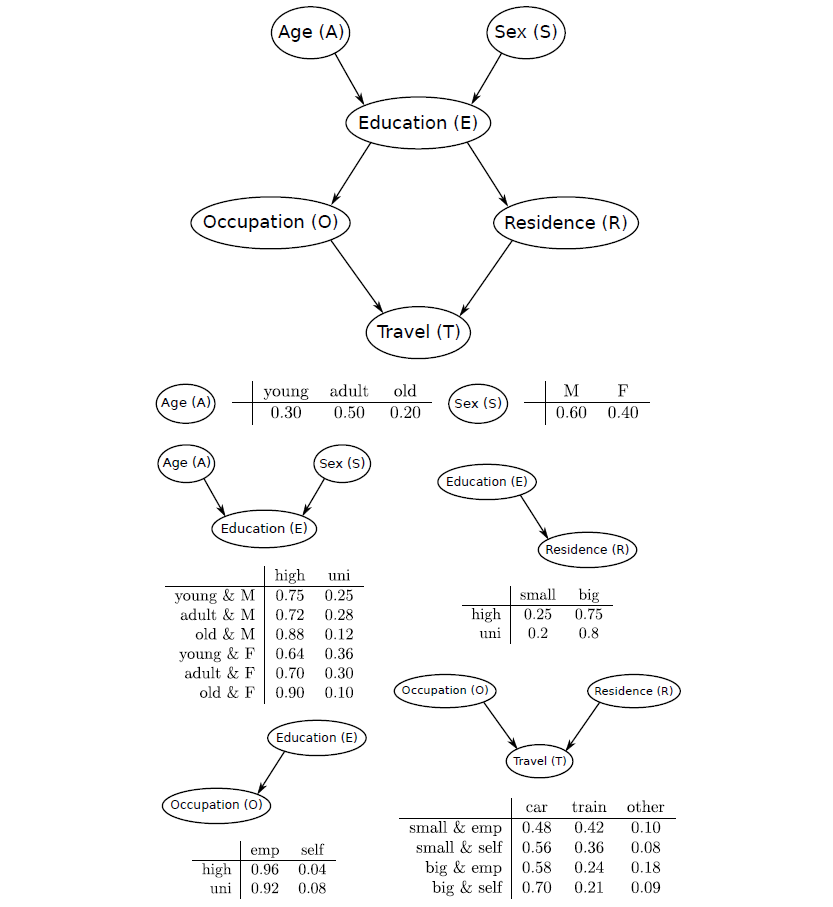

## **K2 Algorithm for Bayesian Network Structure Learning**

The **K2 algorithm**, originally introduced by *Cooper and Herskovits (1992)*, is a heuristic search method for learning the structure of a Bayesian network from data. Bayesian networks are probabilistic graphical representations in which nodes denote random variables and edges encode conditional dependencies, constrained by the requirement of forming a directed acyclic graph (DAG).

The primary goal of the K2 algorithm is to identify a network configuration that **maximizes the posterior probability** of the DAG, given a stipulated ordering of the variables. To efficiently navigate the extensive space of possible network structures, the algorithm employs a greedy search approach.

Instead of exhaustively considering all potential sets of parents for each node—a task that becomes computationally intractable as the number of variables grows—K2 focuses on a **restricted set of candidate parents** based on the predefined ordering. Concretely, K2 aims to:

- Infer a **plausible network structure** from observed data.  
- **Evaluate candidate structures** via a Bayesian scoring criterion.  
- **Avoid directed cycles** and limit the number of parent nodes, thereby reducing the scale of the search space.

### Relevance

The K2 algorithm arose during an early phase of research into _automated probabilistic model construction_ Its foundational insights into Bayesian network structure learning have influenced research in both artificial intelligence and statistics. Although numerous advanced algorithms—such as constraint-based, hybrid, or more sophisticated score-based methods—can surpass K2 in flexibility and robustness, K2 remains advantageous for the following reasons:

- It is **straightforward and intuitive** to implement.  
- It serves as a **baseline** for benchmarking newer methods.  
- It is **instructional**, demonstrating the interplay between scoring metrics and search strategies.  
- It performs effectively in **small- to medium-scale problems**, given a known or justifiable variable ordering.

### Weaknesses and Limitations

Despite its historical importance, the K2 algorithm exhibits several drawbacks:

- **Predetermined variable ordering**: This requirement can introduce strong structural biases and is rarely fulfilled in practice.  
- **Greedy approach**: Once a parent node is added, it cannot be removed, possibly leading to suboptimal structures due to local maxima.  
- **Sensitivity to noise**: Small variations in the data may result in considerable changes to the inferred network.  
- **Scalability**: Although more tractable than exhaustive searches, K2 can still struggle with large variable sets unless additional constraints—such as a maximum number of permissible parents—are employed.


<br>

> **Reference**:  
> Cooper, G. F., & Herskovits, E. (1992). A Bayesian method for the induction of probabilistic networks from data. *Machine Learning*, 9(4), 309–347.

## **Implementation**

The aim of this presentation is to showcase a manual implementation, in R, of the K2 algorithm, checking its performances on a series of datasets, and then comparing the results with those obtained using the ```bcstruct``` library.

### General information on the datasets:

We analyzed the datasets: _INSURANCE_, _CHILD_, _ASIA_, among those listed in [here](https://www.bnlearn.com/bnrepository/):

__INSURANCE__:<br>
&nbsp;&nbsp;Number of nodes: 27<br>
&nbsp;&nbsp;Number of arcs: 52<br>
&nbsp;&nbsp;Number of parameters: 1008<br>
&nbsp;&nbsp;Maximum in-degree: 3<br>

__CHILD__:<br>
&nbsp;&nbsp;Number of nodes: 20<br>
&nbsp;&nbsp;Number of arcs: 25<br>
&nbsp;&nbsp;Number of parameters: 230<br>
&nbsp;&nbsp;Maximum in-degree: 2<br>

__ASIA__:<br>
&nbsp;&nbsp;Number of nodes: 8<br>
&nbsp;&nbsp;Number of arcs: 8<br>
&nbsp;&nbsp;Number of parameters: 18<br>
&nbsp;&nbsp;Maximum in-degree: 2<br>


Just few of the available ones can be imported directly:

In [1]:
data(package = "bnlearn")

Package,Item,Title
<chr>,<chr>,<chr>
bnlearn,alarm,ALARM monitoring system (synthetic) data set
bnlearn,asia,Asia (synthetic) data set by Lauritzen and Spiegelhalter
bnlearn,clgaussian.test,Synthetic (mixed) data set to test learning algorithms
bnlearn,coronary,Coronary heart disease data set
bnlearn,gaussian.test,Synthetic (continuous) data set to test learning algorithms
bnlearn,hailfinder,The HailFinder weather forecast system (synthetic) data set
bnlearn,insurance,Insurance evaluation network (synthetic) data set
bnlearn,learning.test,Synthetic (discrete) data set to test learning algorithms
bnlearn,lizards,Lizards' perching behaviour data set


So to manage the elements of CHILD we need to generate them using the whole belief network (that is stored in the files downloadable from the link above) in the following way:

```R
child_bn <- read.bif("child.bif")
data <- rbn(child_bn, n = 100000)
```

A standard import, instead, looks like this:

```R
data("insurance")
data_imported <- insurance
```

We start working on the _INSURANCE_ dataset.

Loading required namespace: Rgraphviz



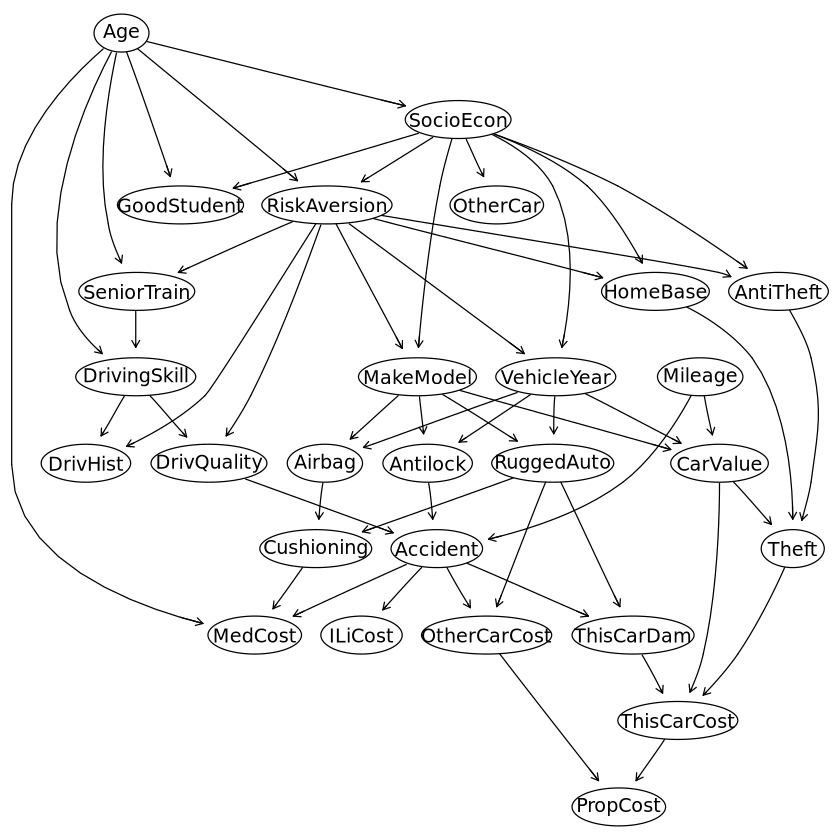

In [2]:
library(bnlearn)

dag_true <- bnlearn::read.net("insurance.net") # Loading the structure from the .net file
dag_true <- bn.net(dag_true)
graphviz.plot(dag_true, shape = "ellipse")

### Manual K2 implementation

In the following we finally start with the implementation of the K2 algorithm, and we will go through it via three sections: _Custom ordering_, _Scoring function_, _K2 implementation_, to then move to _Performance analysis_.

#### Custom ordering

The K2 algorithm is well-known to be _order-dependent_: the result of the algorithm is not robust since it achieves different network structures if node orderings are permuted. Having an ordering of the nodes is, however, one of the fundamental assumptions that the algorithm requires.<br>
Therefore, a way in which this problem is commonly takled to provide a rough implementation, is to generate multiple random node orders, to apply K2 using each node order, and to report which among the belief-network structures output by K2 is the most probable.<br><br>
It is reasonable to state that a meaningful ordering must be somehow representative of the _true_ structure of the data.
However the number of possible structures grows exponentially as a function of the number of nodes.
Thus, a total random sampling from the discrete space of all the possible orderings will not provide an exhaustive exploration.<br><br>
What we implemented then is an ordering that iteratively __improves__ an initial random sequence: at each step, it evaluates possible swaps between the actual _candidate parents_ and the candidate _children_ of the node being considered; for each node. The swap is driven by the the _Bayesian Dirichlet equivalent uniform_ (BDeu) score of the arcs, favoring configurations that improve the overall structure.<br>
This approach arised as an attempt to fix one of the flaws of random ordering, namely that it can completely ignore potentially significant relationships.<br><br>For example, suppose that:
- the set of nodes being cosidered is Z={A,B,C,D};
- it is known that C->B is a strong meaingful relationship.<br>

And let's define:
- P: the set of the forerunners of the node being considered. Here P={A};
- S: the set of the successors of the node being considered. Here S={C,D}.<br>

As we will see in _K2 implementation_, K2 considers candidate parents of a node just those that come before the node in the proposed ordering. Thus, considering all the permutations of the elements of Z, the relationship C->B will be taken into account just 50% of the times.<br>
In the proposed approach instead we evaluate the score of all the arcs _from_ {P U S} _to_ B and we replace the lowest-scoring element of P with the higest-scoring one of S, at each iteration.

In [3]:
optimize_ordering <- function(ordering, data) {
  for (i in seq_along(ordering)) {
    node <- ordering[i]
    S <- if (i > 1) ordering[1:(i-1)] else character(0)
    Z <- if (i < length(ordering)) ordering[(i+1):length(ordering)] else character(0)

    if (length(Z) == 0 || length(S) == 0) next

    scores_S <- sapply(S, function(s) score_arc(s, node, data))
    scores_Z <- sapply(Z, function(z) score_arc(z, node, data))

    min_s_idx <- which.min(scores_S)
    max_z_idx <- which.max(scores_Z)

    if (scores_Z[max_z_idx] > scores_S[min_s_idx]) {
      s_to_replace <- S[min_s_idx]
      z_to_insert <- Z[max_z_idx]
      
      # Swap in ordering
      idx_s <- which(ordering == s_to_replace)
      idx_z <- which(ordering == z_to_insert)
      ordering[c(idx_s, idx_z)] <- ordering[c(idx_z, idx_s)]
    }
  }
  return(ordering)
}

#### Scoring function

The scoring function to use to drive the swaps is the Bayesian Dirichlet equivalent uniform (BDeu) score, applied to single arcs, so the arc _from_ each of the candidates and "illegal" parents, _to_ the node being tested. It is directly applicable from the ```bnlearn``` library:

In [4]:
score_arc <- function(from, to, data, iss = 1) {
  bn <- empty.graph(names(data))
  arcs(bn) <- matrix(c(from, to), ncol = 2, byrow = TRUE, dimnames = list(NULL, c("from", "to")))
  score(bn, data = data, type = "bde", iss = iss)
}

#### K2 implementation

**Pseudocode**:

_Input_:
- `D`: A dataset of complete cases (no missing data), where each row is an observation.
- `n`: Number of variables.
- `ordering`: An ordering of the variables (e.g., `[X1, X2, ..., Xn]`).
- `u`: A user-specified maximum number of parents per node.

_Output_:
- A DAG representing the learned structure.

_Algorithm_:

```text
For i = 1 to n:
    π_i ← ∅    # Initialize parent set for node Xi
    P_old ← Score(Xi | π_i)

    Repeat:
        Let Z be the variable (preceding Xi in the ordering) 
        not in π_i such that adding Z to π_i maximizes Score(Xi | π_i ∪ {Z})

        If π_i ∪ {Z} improves the score and |π_i| < u:
            π_i ← π_i ∪ {Z}
            P_old ← Score(Xi | π_i)
        Else:
            Break



**Score function**: <br>
The 'Score(Xi | π_i)' is a _Bayesian scoring metric_ that reflects how well a variable is explained by its parents in the data. The function assumes all variables are discrete and complete, and it is based on a marginal likelihood derived from Bayes' theorem.
The score for a variable $X_i$ with a candidate parent set $\Pi_i$ is given by the **Cooper–Herskovits metric**:

$$
\text{Score}(X_i \mid \Pi_i) 
= \prod_{j=1}^{q_i} \left[ \frac{(r_i - 1)!}{(N_{ij} + r_i - 1)!} \prod_{k=1}^{r_i} N_{ijk}! \right]
$$

where:  
- $r_i$: Number of discrete states (values) of variable $X_i$  
- $q_i$: Number of unique instantiations of the parent set $\Pi_i$  
- $N_{ijk}$: Number of data cases where the parents $\Pi_i$ are in their $j$-th instantiation and $X_i$ is in its $k$-th state  
- $N_{ij} = \sum_{k=1}^{r_i} N_{ijk}$: Total number of cases where the parents are in their $j$-th instantiation

<br>

_Interpretation_:<br>
- The score **increases** when the parent configuration predicts the child variable well.  
- It **penalizes complex structures** that do not significantly improve the likelihood, helping to avoid overfitting.  
- The function is **decomposable**, meaning the total score of the network is the sum of local scores, one for each node.

<br>

_Practical Notes_:

In practice, the score is often computed in _log-space_ to avoid numerical underflow:

$$
\log \text{Score}(X_i \mid \Pi_i) 
= \sum_{j=1}^{q_i} 
\left[ 
\log \Gamma(r_i) 
- \log \Gamma(N_{ij} + r_i) 
+ \sum_{k=1}^{r_i} \log \Gamma(N_{ijk} + 1) 
\right]
$$

In most languages: `lgamma(n + 1)` returns $\log(n!)$, and the gamma function generalizes the factorials: $\Gamma(n+1) = n!$.


> **Reference**:  
> Cooper, G. F., & Herskovits, E. (1992). A Bayesian method for the induction of probabilistic networks from data. *Machine Learning*, 9(4), 309–347.

In [5]:
manual_k2 <- function(data, ordering, u = 5) {
  n <- length(ordering)
  nodes_list <- lapply(data, levels)
  names_idx <- match(ordering, names(data))  # Get index of variables in new order
  
  f <- function(q, r, combos, alfa, N) {          
    alfa_mat <- matrix(alfa, nrow = r)            
    N_vec <- colSums(alfa_mat)                
    f_val <- sum(
      lgamma(r) - lgamma(N_vec + r) +            
        colSums(lgamma(alfa_mat + 1))                
    )
    f_val
  }

  parents <- vector("list", n)
  for (i in seq_along(parents)) {
    parents[[i]] <- integer(0)
  }

  #K2 standard implementation
  for (i in seq_along(ordering)) {
    node <- ordering[i]
    node_idx <- names_idx[i]
    r <- length(nodes_list[[node]])
    alfa0 <- table(data[, node])
    alfa0 <- matrix(alfa0, nrow = r)
    N0 <- colSums(alfa0)
    f_old <- f(1, r, NULL, alfa0, N0)
    n_parents <- 0
    
    while (n_parents < u) {
      f_cand_list <- c()
      candidate_parents <- names_idx[seq_len(i - 1)]
      
      for (p in candidate_parents) {
        current_parents <- parents[[node_idx]]
        proposed_parents <- unique(c(current_parents, p))
        
        parent_levels_list <- lapply(proposed_parents, function(l) nodes_list[[l]])
        combos_current <- expand.grid(parent_levels_list, stringsAsFactors = FALSE)
        q <- if (length(parent_levels_list) == 0) 1 else nrow(combos_current)
        
        alfa <- table(data[, c(node_idx, proposed_parents)])
        N <- colSums(matrix(alfa, nrow = r))
        f_cand_list <- c(f_cand_list, f(q, r, combos_current, alfa, N))
      }
      
      if (length(f_cand_list) == 0) break
      idx <- which.max(f_cand_list)
      f_cand <- f_cand_list[idx]
      
      if (f_cand > f_old) {
        parents[[node_idx]] <- c(parents[[node_idx]], candidate_parents[idx])
        f_old <- f_cand
        n_parents <- n_parents + 1
      } else break
    }
  }

  # Build edges
  edges <- do.call(
    rbind,
    lapply(seq_along(parents), function(child) {
      if (length(parents[[child]]) == 0) return(NULL)
      cbind(from = names(data)[parents[[child]]],
            to   = rep(names(data)[child], length(parents[[child]])))
    })
  )
  
  return(list(edges = edges, parents = parents))
}

#### Running the algoritm

Defining some "hyperparameters":

In [6]:
library(bnlearn)
set.seed(32)

data("insurance")
data_insurance <- insurance

node_names <- names(data_insurance)
n <- length(data_insurance)
nodes_list <- lapply(data_insurance, levels)

n_iterations <- 25 #number of times the ordering is updated (starting from the result of the previous iteration)
n_random <- 25 #number of random ordering trials
u <- 3 #max number of parents per ndoe

Loop that performs multiple runs over a given ```ordering_list```:

In [7]:
run_k2_batch <- function(data, orderings_list, u = u) {
  node_names <- names(data)
  n_iter <- length(orderings_list)
  
  bic_scores <- numeric(n_iter)
  dags <- vector("list", n_iter)
  parents_all <- vector("list", n_iter)
  
  for (i in seq_along(orderings_list)) {
    ordering <- orderings_list[[i]]
    
    res <- manual_k2(data, ordering, u)
    edges <- res$edges
    parents_all[[i]] <- res$parents
    
    #translating to character matrix if necessary
    if (!is.null(edges)) {
      if (is.numeric(edges)) {
        edges <- matrix(node_names[edges], ncol = 2, dimnames = list(NULL, c("from", "to")))
      }
      if (ncol(edges) != 2)
        stop("Edge list for iteration ", i, " does not have 2 columns.")
    }
    
    #DAG building
    dag_i <- empty.graph(nodes = node_names)
    if (!is.null(edges) && nrow(edges) > 0)
      arcs(dag_i) <- edges
    
    dags[[i]] <- dag_i
    bic_scores[i] <- score(dag_i, data = data, type = "bic")
  }
  
  list(
    orderings = orderings_list,
    bic_scores = bic_scores,
    dags = dags,
    parents = parents_all
  )
}


Custom ordering run:

In [8]:
initial_ordering <- sample(names(data_insurance))
orderings_list <- list(initial_ordering)                              
for (i in seq_len(n_iterations)) {
  new_ordering <- optimize_ordering(orderings_list[[i]], data_insurance)
  #Early stopping if ordering doesn't change
  if (identical(new_ordering, orderings_list[[i]])) {
    message("Ordering stabilized at iteration ", i)
    break
  }
  orderings_list[[i + 1]] <- new_ordering
}
                                     
refined_run_insurance <- run_k2_batch(data_insurance, orderings_list, u = u)

Run over the first element of 'orderings_list', so over a completely random order:

In [9]:
#results for the random initialization                                    
result_r <- manual_k2(data_insurance, initial_ordering, u)
edges_r <- result_r$edges
parents_r <- result_r$parents

dag_random <- empty.graph(nodes = names(data_insurance))
arcs(dag_random) <- edges_r
bic_random <- score(dag_random, data = data_insurance, type = "bic")  

Repeated run over random orderings:

In [10]:
random_orderings <- lapply(seq_len(n_random), function(i) sample(node_names))
random_run <- run_k2_batch(data=data_insurance, orderings_list=random_orderings, u=u)

#### Performance analysis

The performances are compared evaluating the _Bayesian Information criterion_ (BIC) score.<br>
BIC is a network score, are goodness-of-fit statistics measuring how well the DAG mirrors the dependence structure of the data, considering the DAG as a whole.<br>
It is defined as:

$$
\mathrm{BIC}
= \log P(S)\;-\;\frac{d}{2}\,\log n
$$

where:
- P(S) is the joint probability of all the nodes of the network,  
- d is the total number of free parameters,  
- n is the sample size.

So the higher the score, the better.<br>

We also compare the output structures graphically, using the ```graphviz.compare()``` function, by plotting the structures corresponding to some of the highest BIC scores, and highligting their differences; see the next paragraph for further details.

In [11]:
plot_k2_diagnostics <- function(refined_run, random_run, top_k = 10, layout  = "dot") {
  par(mfrow = c(1, 1))
  plot(refined_run$bic_scores,
       type = "b",  pch = 19, lwd = 2,
       xlim = c(0, n_iterations + 1),
       xlab = "Iteration",
       ylab = "BIC score",
       main = "BIC evolution: custom refinement vs random orderings")
  lines(seq_along(random_run$bic_scores),
       random_run$bic_scores,
       type = "b", pch = 17, lwd = 2,
       col  = "orange", lty = 3)
  abline(h = bic_random, col = "red", lty = 2, lwd = 3)
  abline(h = mean(refined_run$bic_scores),  col = "black", lty = 2, lwd = 3)
  legend("topright",
    legend = c("custom", "custom mean", "multiple rand", "single rand"),
    col = c("black", "black", "orange", "red"),
    lty = c(1, 2, 3, 2),
    pch = c(19, NA, 17, NA),
    lwd = 2, pt.cex  = 1, bty = "n")


  top_idx <- order(refined_run$bic_scores, decreasing = TRUE)[1:top_k]
  top_dags <- refined_run$dags[top_idx]
  n_row <- ceiling(top_k / 5)
  par(mfrow = c(n_row, 5))
  for (k in seq_along(top_dags)) {
    bnlearn::graphviz.plot(top_dags[[k]], shape = "ellipse", main  = paste("BIC =", round(refined_run$bic_scores[top_idx[k]], 1)))
  }
  par(mfrow = c(n_row, 5))
  do.call(bnlearn::graphviz.compare, c(top_dags, list(layout = layout)))
}


The ```graphviz.compare()``` function provides a visual comparison of the networks structures by plotting them side by side (with the same node ordering) and highlighting differences between all networks listed after the first one (referred to as 'current') with respect to the first one ('target').<br>
The differences are highlighted using the following color scheme:
- in the 'current' networks _true positive_ arcs are in black;
- _false positive_ arcs are in red;
- _false negative_ arcs are in blue, and drawn using a dashed line<br>

Where:
- _true positives_ are arcs which appear both in 'target' and in 'current';
- _false positives_ are arcs which appear in 'current' but not in 'target', both missing **or** having different directions in 'target';
- _false negatives_ are arcs which appear in 'target' but not in 'current'.

<br>
Let's look at the results:

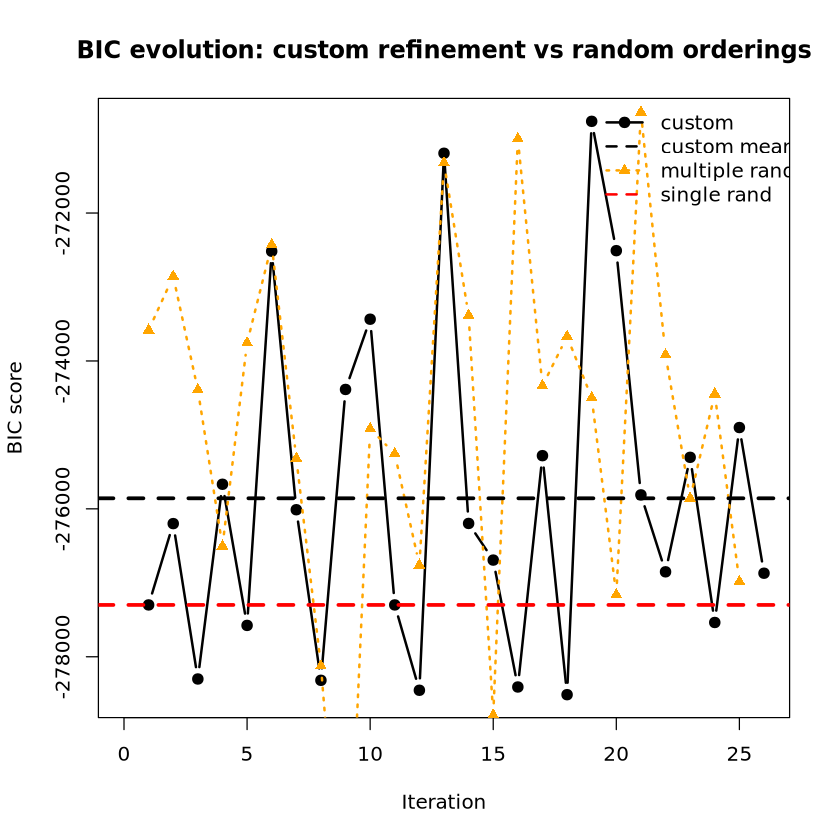

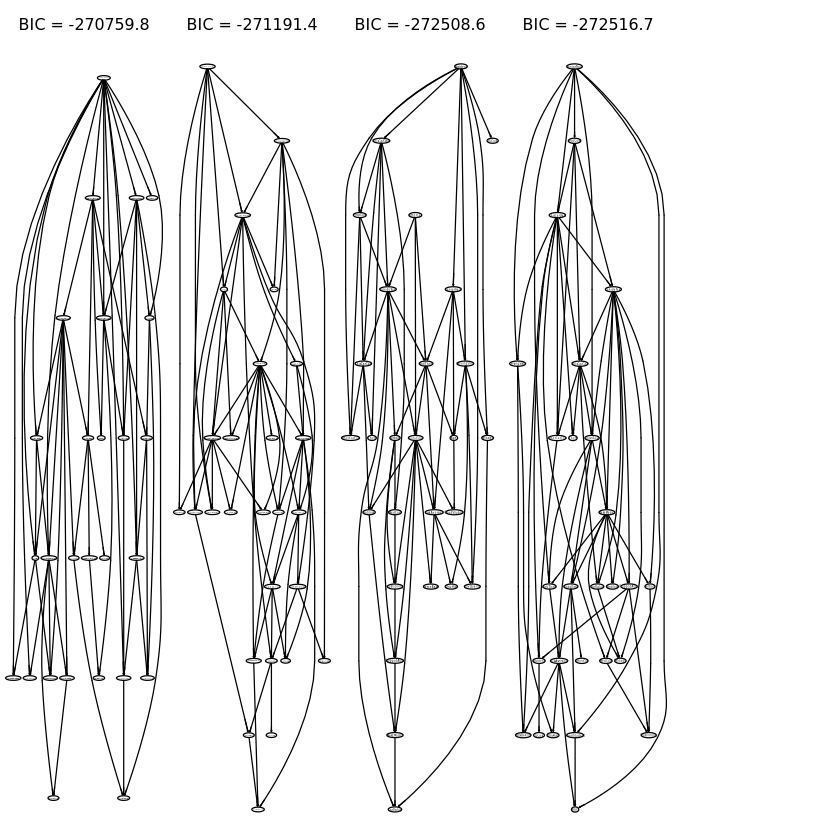

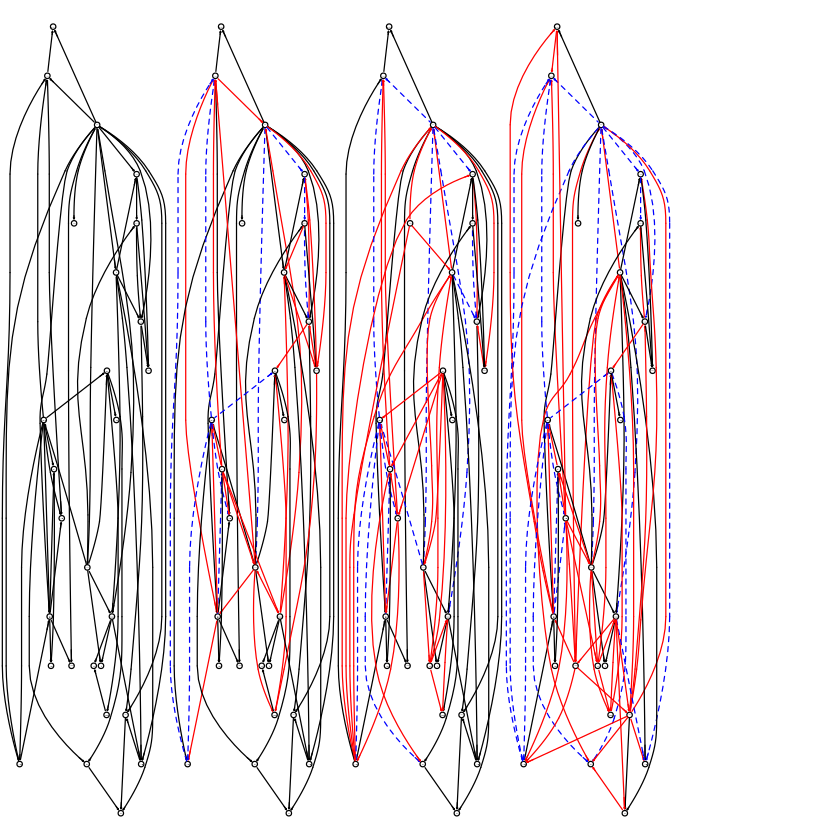

In [12]:
plot_k2_diagnostics(refined_run = refined_run_insurance, random_run = random_run, top_k = 4)

_Note_: These DAG plots are there not to show the structure itself, but just to provide a raw graphical comparison between the various results, meant to highlight just the main differences. For a more detailed inspection of the DAGs see the paragraph _Sanity checks_.

Analyzing the results it emerges that the new ordering, in terms of the BIC, performs similarly to a random sampling of the order of the features, and that the structures with the highest BIC are very little comparable between eachother; so these results do not support the new method.<br>
However, before discarding this new method, we must consider that, by not caring about the meaning of the nodes as we're doing, BIC may find relevant dependencies that, instead, are spurious actually. This can infact be seen efficiently using the _SURVEY_ dataset, since its nodes (and therefore their dependecies) are easily interpretable:

In [13]:
survey_bn <- bnlearn::read.bif("survey.bif")
data_survey <- rbn(survey_bn, n = 30000)
node_names_survey <- names(data_survey)
u <- 3                     
n_iterations <- 10
n_random <- 10

#random orderings
random_orderings <- lapply(seq_len(n_random), function(i) sample(node_names_survey))
random_run <- run_k2_batch(data = data_survey, orderings_list  = random_orderings, u = u)

#custom ordering
initial_ordering <- sample(node_names_survey) 
orderings_list_survey <- list(initial_ordering)

for (i in seq_len(n_iterations)) {
  new_ordering <- optimize_ordering(orderings_list_survey[[i]], data_survey)
  
  if (identical(new_ordering, orderings_list_survey[[i]])) {
    message("Ordering stabilized at iteration ", i)
    break
  }
  orderings_list_survey[[i + 1]] <- new_ordering
}
refined_run_survey <- run_k2_batch(data = data_survey, orderings_list  = orderings_list_survey, u = u)

Ordering stabilized at iteration 3



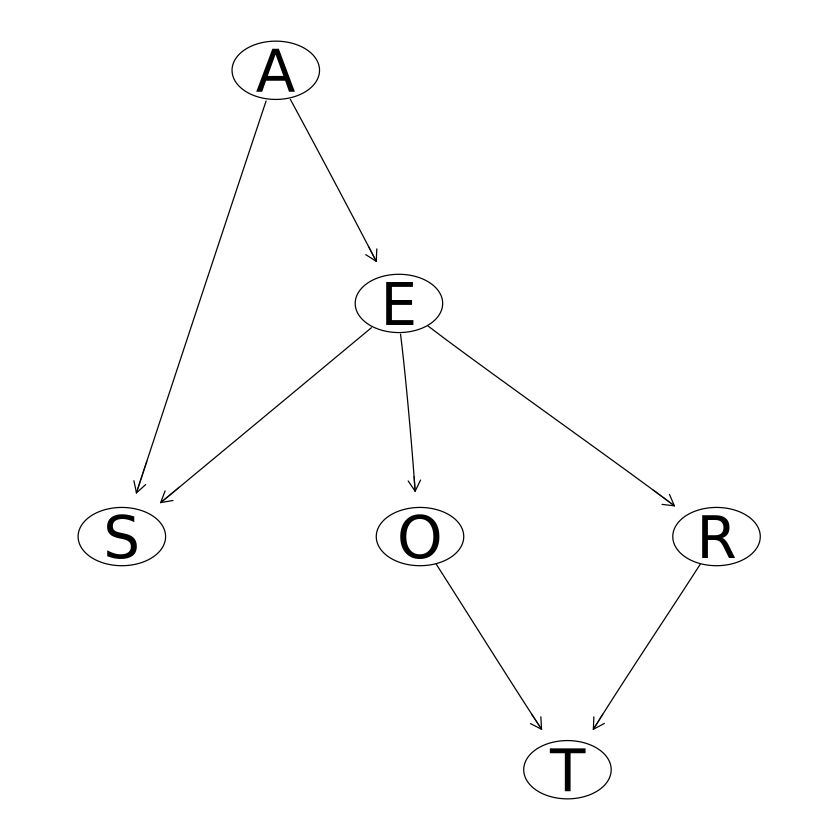

In [14]:
graphviz.plot(refined_run_survey$dags[[length(refined_run_survey$dags)]],shape = "ellipse")

Among possible others dependencies, _Age_ being parent of _Sex_ is a spurious one.<br>
It is therefore evident that some prior knowledge should be included in the ordering of the nodes, for example avoiding that _Sex_ and _Age_ can influence eachother.<br>
However, even leaving aside the practical difficulty of implementing K2 with both custom ordering and this type of prior knowledge, when nodes start growing in number it quickly becomes challenging being able to efficiently and correctly determine even the most significant relationships. Thus, trying to get prior knowledge manually may not be the most reasonable approach to improve the ordering.

### Sanity check

Let's test whether the K2 algorithm, when provided with a consistent order of the nodes, is able to find the correct structure of the bayesian network.

To do so: 
- we consider the data from the _INSURANCE_ dataset;
- we get the consistent ordering using a topological sort of the DAG: a node is added to the "ordered set" only when all its parents are already in the list (so to respect the parent-before-child constraint).

In [15]:
dag_true_insurance <- bnlearn::read.net("insurance.net") # Loading the structure from the .net file
topo_order <- bnlearn::node.ordering(dag_true_insurance) # Get topological ordering

dag_true_insurance <- bn.net(dag_true_insurance) #To make the 'compare' method work, the target network needs to be of class 'bn'
bic_true <- bnlearn::score(dag_true_insurance, data = data_insurance, type = "bic")

u <- 3
result_s <- manual_k2(data_insurance, topo_order, u)
edges_s <- result_s$edges
parents_s <- result_s$parents

dag_s <- empty.graph(nodes = node_names)
arcs(dag_s) <- edges_s
bic_s <- bnlearn::score(dag_s, data = data_insurance, type = "bic")
   
comparison <- bnlearn::compare(dag_true_insurance, dag_s)
total_arcs <- comparison$tp + comparison$fn

In [16]:
bnlearn::compare(dag_true_insurance, dag_s) #The first network is taken as the “true” network

$tp
[1] 45

$fp
[1] 1

$fn
[1] 7

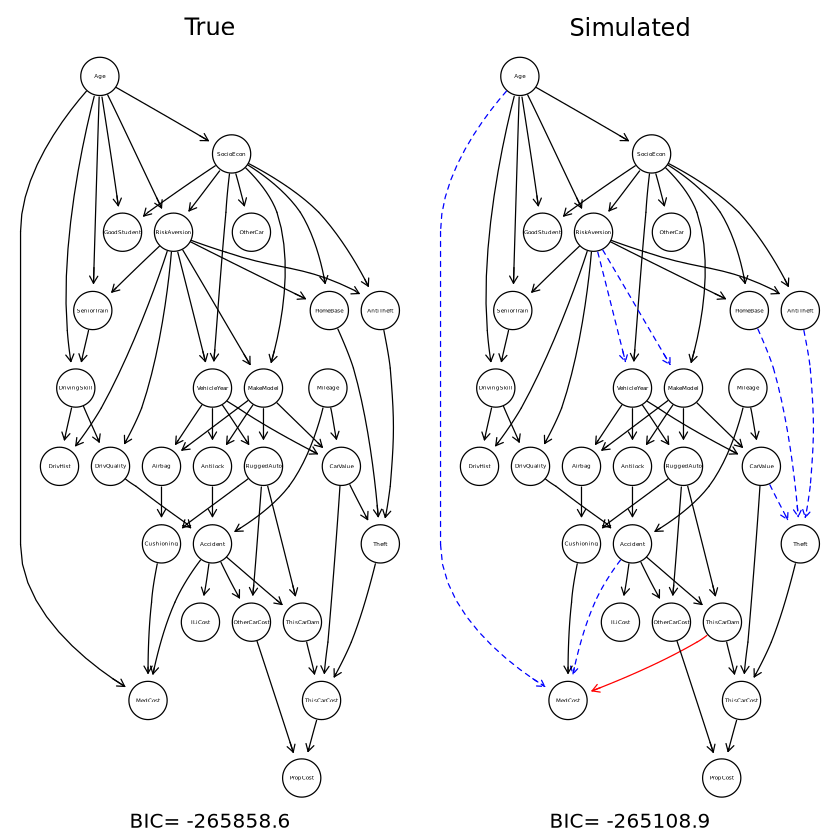

In [17]:
par(mfrow = c(1, 2))
graphviz.compare(dag_true_insurance, dag_s, layout="dot",
                 main = c("True", "Simulated"),
                 sub = c(paste("BIC=",as.character(round(bic_true,1))), paste("BIC=",as.character(round(bic_s,1))))) #The first network is taken as the “true” network

Output interpretation:
- **tp**: true positives;
- **fp**: false positives;
- **fn**: false negatives.

Color scheme: _same as above_

Let's test the significance of the arcs removed, via _Conditional Independence_ (CI) tests: since each arc encodes a probabilistic dependence, conditional independence tests can be used to assess whether that probabilistic dependence is supported by the data.<br>They are hypotheses testing tests, that evaluate whether the null hypothesis of conditional independence can or can not be rejected; the null hypothesis is rejected for large values of the test statistics.<br>
Here we use the version based on the Pearson's $\chi^2$. It is defined as follows:<br>

$$H_0:\; X \;\perp\!\!\!\perp\; Y \mid Z$$
$$
\chi^2(X,Y \mid Z)\;=\;
\sum_{k=1}^{q_Z}\,
\sum_{i=1}^{r_X}\,
\sum_{j=1}^{r_Y}
\frac{\Bigl(n_{ijk}
           \;-\;
           \dfrac{n_{i\cdot k}\,n_{\cdot j k}}{n_{\cdot\cdot k}}\Bigr)^2}
     {\dfrac{n_{i\cdot k}\,n_{\cdot j k}}{n_{\cdot\cdot k}}}
\;\;\;\;\stackrel{H_0}{\sim}\;
\chi^2\!\bigl((r_X-1)(r_Y-1)q_Z\bigr)\
$$

* $r_X,\; r_Y$ – number of categories of $X$ and $Y$  
* $q_Z$ – number of distinct configurations of the conditioning set $Z$  
* $n_{ijk}$ – observed cell count for $X=i,\;Y=j,\;Z=k$  
* $n_{i\cdot k}=\sum_{j} n_{ijk}$, $n_{\cdot j k}=\sum_{i} n_{ijk}$, $n_{\cdot\cdot k}=\sum_{i,j} n_{ijk}$  
* Degrees of freedom of the asymptotic $\chi^2$ distribution that the startistics follow: $(r_X-1)(r_Y-1)q_Z$

It can be implemented straight away using the ```ci.test()``` function from ```bnlearn```, specifying the kind of test to use.

In [18]:
test_false_negatives <- function(dag_true, dag_learned, data, alpha = 0.05, test_type = "x2") {
  #Comparing the two DAGs
  cmp <- bnlearn::compare(dag_true, dag_learned, arcs = TRUE)
  fn_arcs <- cmp$fn 
  if (is.null(fn_arcs) || nrow(fn_arcs) == 0) {
    warning("No false-negative arcs to test.")
    return(NULL)
  }
  
  # Initializing results storage
  test_results <- data.frame(
    from = fn_arcs[, "from"],
    to = fn_arcs[, "to"],
    statistic = NA_real_,
    p.value = NA_real_,
    independent = NA,
    stringsAsFactors = FALSE
  )

  #Testing false negatives
  for (i in seq_len(nrow(fn_arcs))) {
    tail <- fn_arcs[i, "from"]
    head <- fn_arcs[i, "to"]
    
    cond_set <- setdiff(bnlearn::parents(dag_true, head), tail)
    if (length(cond_set) == 0) cond_set <- NULL
    
    ci <- ci.test(
      x = tail,
      y = head,
      z = cond_set,
      test = test_type,
      data = data
    )
    
    test_results$statistic[i] <- ci$statistic
    test_results$p.value[i] <- ci$p.value
    test_results$independent[i] <- (ci$p.value > alpha)
  }
  return(test_results)
}

In [19]:
dag_true = dag_true_insurance
dag_learned = dag_s
alpha = 0.05
test_type = "x2"

test_results<-test_false_negatives(dag_true, dag_learned, data_insurance, alpha, test_type)
print(test_results)

          from          to   statistic      p.value independent
1          Age     MedCost  146.238847 0.0007310574       FALSE
2 RiskAversion VehicleYear   14.479973 0.2711132171        TRUE
3 RiskAversion   MakeModel   24.054477 0.9984836948        TRUE
4     Accident     MedCost 6911.078250 0.0000000000       FALSE
5     CarValue       Theft   32.115634 0.4610189586        TRUE
6     HomeBase       Theft   44.952151 0.0389992483       FALSE
7    AntiTheft       Theft    2.567795 0.9999989499        TRUE


So just three of them appear to be actually meaningful, and we may want to remove the others:

In [20]:
arcs_to_remove <- test_results[test_results$independent == TRUE, ]
for (i in seq_len(nrow(arcs_to_remove))) {
  dag_true <- bnlearn::drop.arc(
    dag_true, 
    from = arcs_to_remove$from[i], 
    to = arcs_to_remove$to[i]
  )
}

print(paste("True BIC =",round(bnlearn::score(dag_true, data = data_insurance, type = "bic"),1)))
print(paste("Simulated BIC =",round(bnlearn::score(dag_s, data = data_insurance, type = "bic"),1)))

[1] "True BIC = -265419.4"
[1] "Simulated BIC = -265108.9"


### Other datasets

As an excercise we run this implementation of the ordering on the other two datasets mentioned in the beginnig: _ASIA_ and _CHILD_, which may still be meaningful since CHILD has a different structure than INSURANCE, and ASIA has few nodes.

_CHILD_:

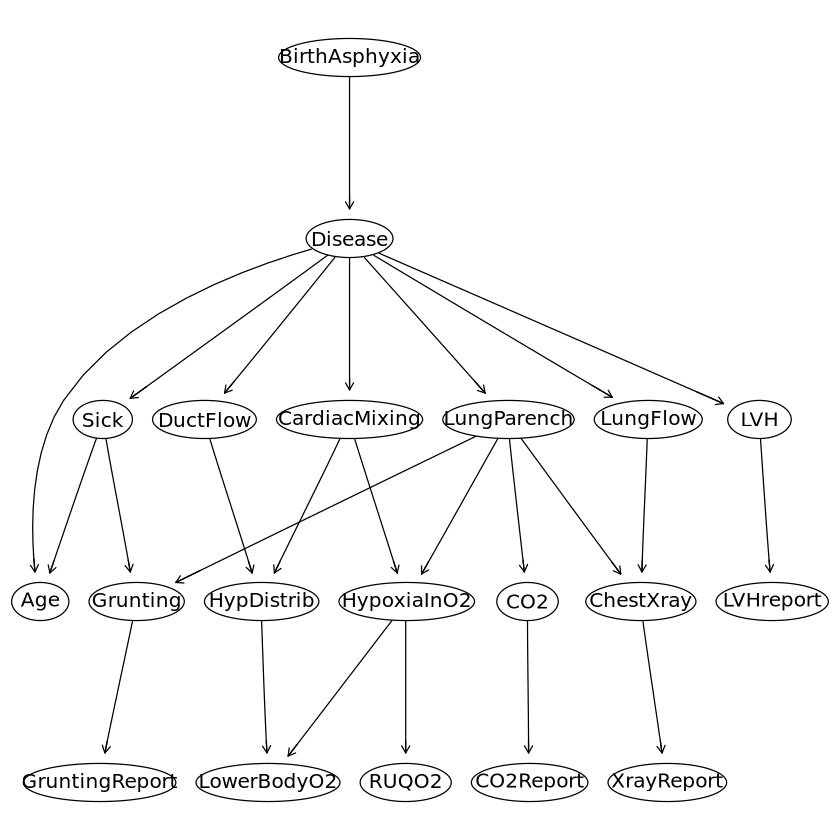

In [21]:
dag_true_child <- bnlearn::read.net("child.net") # Loading the structure from the .net file
dag_true_child <- bn.net(dag_true_child)
graphviz.plot(dag_true_child, shape = "ellipse")

In [42]:
child_bn <- bnlearn::read.bif("child.bif")
data_child <- rbn(child_bn, n = 30000)

node_names <- names(data_child)
n <- length(data_child)
nodes_list <- lapply(data_child, levels)

n_iterations <- 50 #number of times the ordering is updated (starting from the result of the previous iteration)
n_random   <- 50 #number of random ordering trials
u <- 2 #max number of parents per ndoe

In [57]:
#custom ordering
initial_ordering <- sample(names(data_child))
orderings_list <- list(initial_ordering)                              
for (i in seq_len(n_iterations)) {
  new_ordering <- optimize_ordering(orderings_list[[i]], data_child)
  #Early stopping if ordering doesn't change
  if (identical(new_ordering, orderings_list[[i]])) {
    message("Ordering stabilized at iteration ", i)
    break
  }
  orderings_list[[i + 1]] <- new_ordering
}
refined_run_child <- run_k2_batch(data_child, orderings_list, u = u)

#single random initialization                                    
result_r <- manual_k2(data_child, initial_ordering, u)
edges_r <- result_r$edges
parents_r <- result_r$parents

dag_random <- empty.graph(nodes = names(data_child))
arcs(dag_random) <- edges_r
bic_random <- score(dag_random, data = data_child, type = "bic")  

#multiple random initialization
random_orderings <- lapply(seq_len(n_random), function(i) sample(node_names))
random_run <- run_k2_batch(data=data_child, orderings_list=random_orderings, u=u)

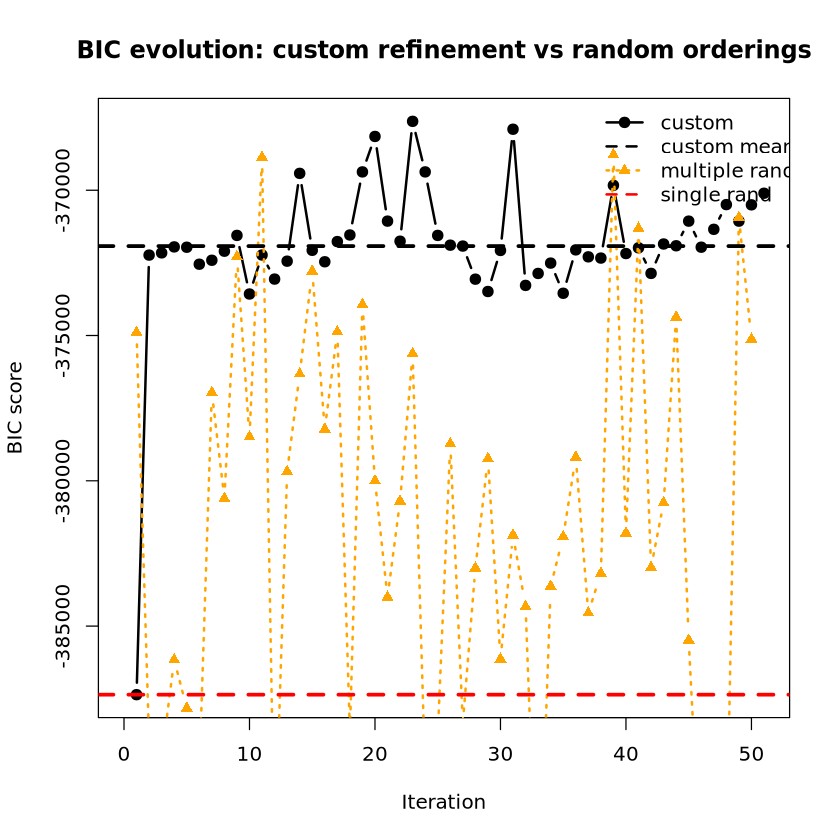

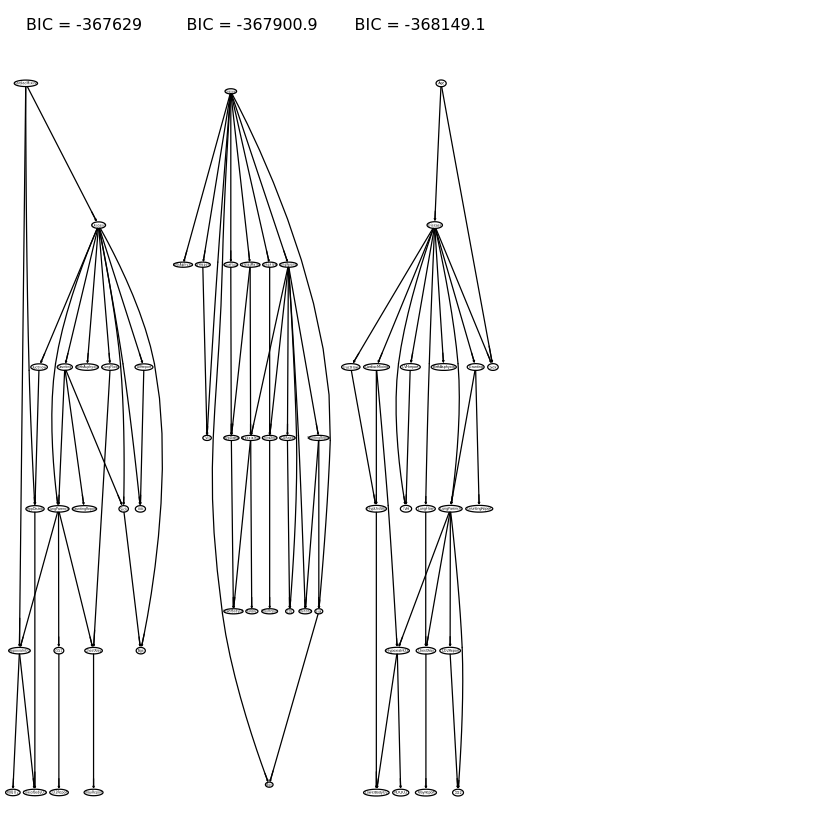

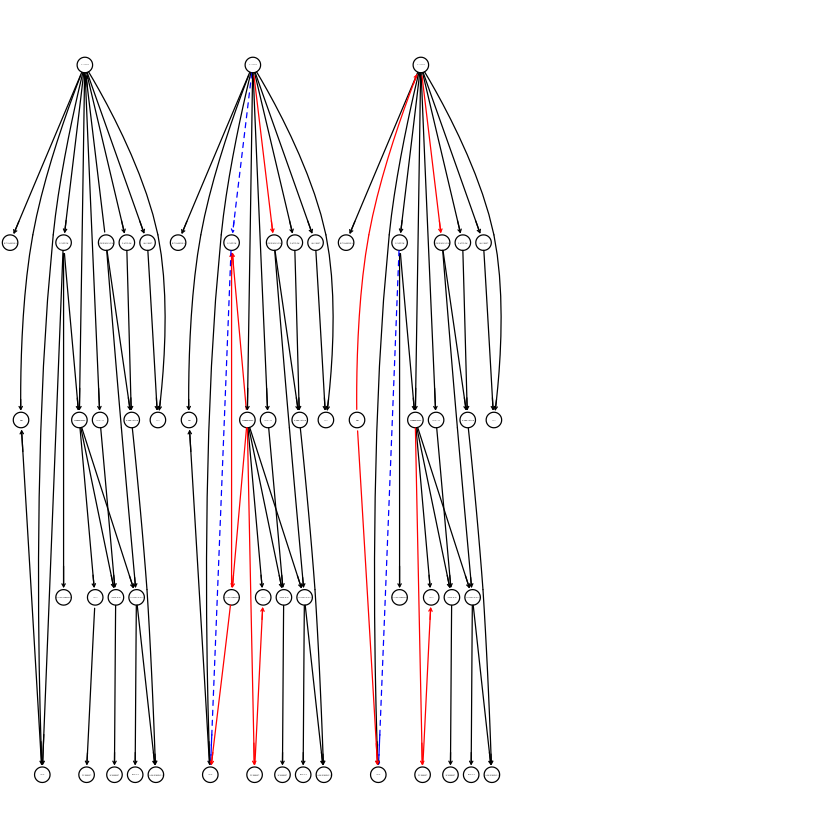

In [63]:
#plotting:
plot_k2_diagnostics(refined_run = refined_run_child, random_run = random_run, top_k = 3)

The BIC behaviour looks promising since it is more or less stable (however the steep jump that takes place between the first and the second iteration is suspicious). Let's then compare with the real structure both the DAG with the best BIC and one with an average one:

[1] "True vs Best_BIC:"


$tp
[1] 20

$fp
[1] 7

$fn
[1] 5

[1] "True vs Avg_BIC:"


$tp
[1] 17

$fp
[1] 12

$fn
[1] 8

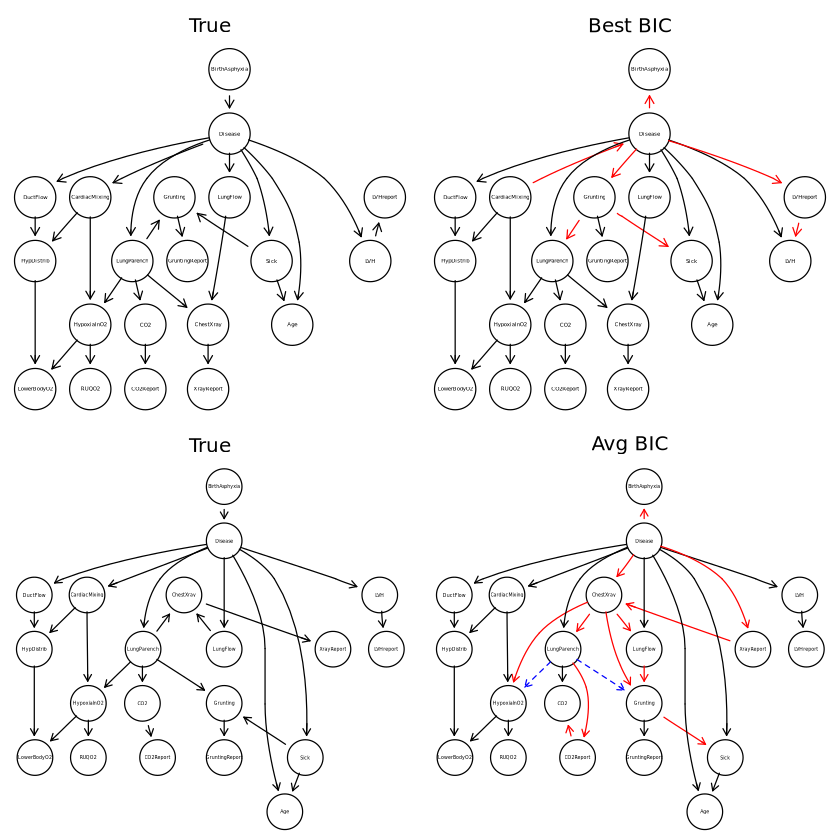

In [65]:
top_idx_child <- order(refined_run_child$bic_scores, decreasing = TRUE)[1:3]
top_dags_child <- refined_run_child$dags[top_idx_child]

print("True vs Best_BIC:")
bnlearn::compare(dag_true_child, top_dags_child[[1]])
print("True vs Avg_BIC:")
bnlearn::compare(dag_true_child, refined_run_child$dags[[4]])

par(mfrow = c(2, 2))
graphviz.compare(dag_true_child, top_dags_child[[1]], layout="dot", main = c("True", "Best BIC"))
graphviz.compare(dag_true_child, refined_run_child$dags[[4]], layout="dot", main = c("True", "Avg BIC"))

_Note_: **fn** in both cases doesn't match the number of the dashed blue lines actually plotted, but this happens because both the missing and the wrongly-directed arcs are considered as false _positives_, so the red signature may overlap the blue one. The consistency of the plot can infact be confirmed by adding the option ```arcs=TRUE``` in ```compare()```, which returns the corresponding arc set for each of the three cases (tp, fn, fp).

So the network with the best BIC is actually pretty close to the true one as a metter of __undirected__ arcs, since it includes all the arcs of the true network (so there are no missing relationships) but there are two new ones. When it comes to the directions however, there are _fp_ (7) misdirected connections.<br>
Nevertheless we still mark this as a positive result because:
- both the extra connections can easily be ignored by an _expert_ because of where the interested nodes belong to in the true structure;
- some of the misdirected connections can be easily spotted by an expert, for example _Disease_ -> _BirthAsphyxia_.

_ASIA_:

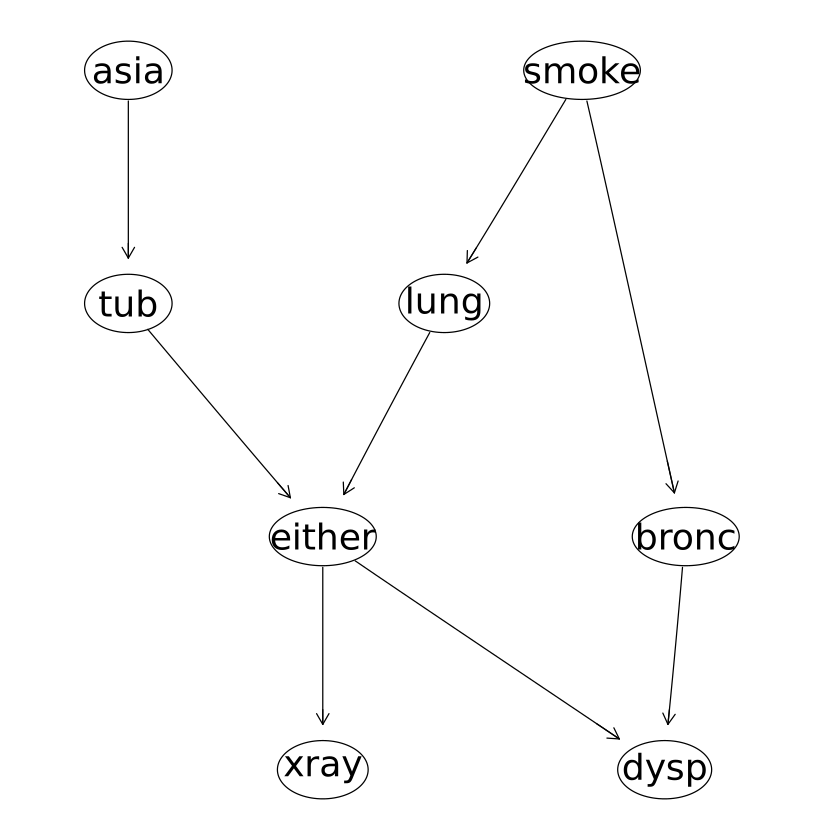

In [78]:
dag_true_asia <- bnlearn::read.net("asia.net") # Loading the structure from the .net file
dag_true_asia <- bn.net(dag_true_asia)
graphviz.plot(dag_true_asia, shape = "ellipse")

In [27]:
data("asia")
data_asia <- asia

node_names <- names(data_asia)
n <- length(data_asia)
nodes_list <- lapply(data_asia, levels)

n_iterations <- 25 #number of times the ordering is updated (starting from the result of the previous iteration)
n_random   <- 25 #number of random ordering trials
u <- 2 #max number of parents per ndoe
                                     
set.seed(32)

In [28]:
#custom ordering
initial_ordering <- sample(names(data_asia))
orderings_list <- list(initial_ordering)                              
for (i in seq_len(n_iterations)) {
  new_ordering <- optimize_ordering(orderings_list[[i]], data_asia)
  #Early stopping if ordering doesn't change
  if (identical(new_ordering, orderings_list[[i]])) {
    message("Ordering stabilized at iteration ", i)
    break
  }
  orderings_list[[i + 1]] <- new_ordering
}
refined_run_asia <- run_k2_batch(data_asia, orderings_list, u = u)

#single random initialization                                    
result_r <- manual_k2(data_asia, initial_ordering, u)
edges_r <- result_r$edges
parents_r <- result_r$parents

dag_random <- empty.graph(nodes = names(data_asia))
arcs(dag_random) <- edges_r
bic_random <- score(dag_random, data = data_asia, type = "bic")  

#multiple random initialization
random_orderings <- lapply(seq_len(n_random), function(i) sample(node_names))
random_run <- run_k2_batch(data=data_asia, orderings_list=random_orderings, u=u)

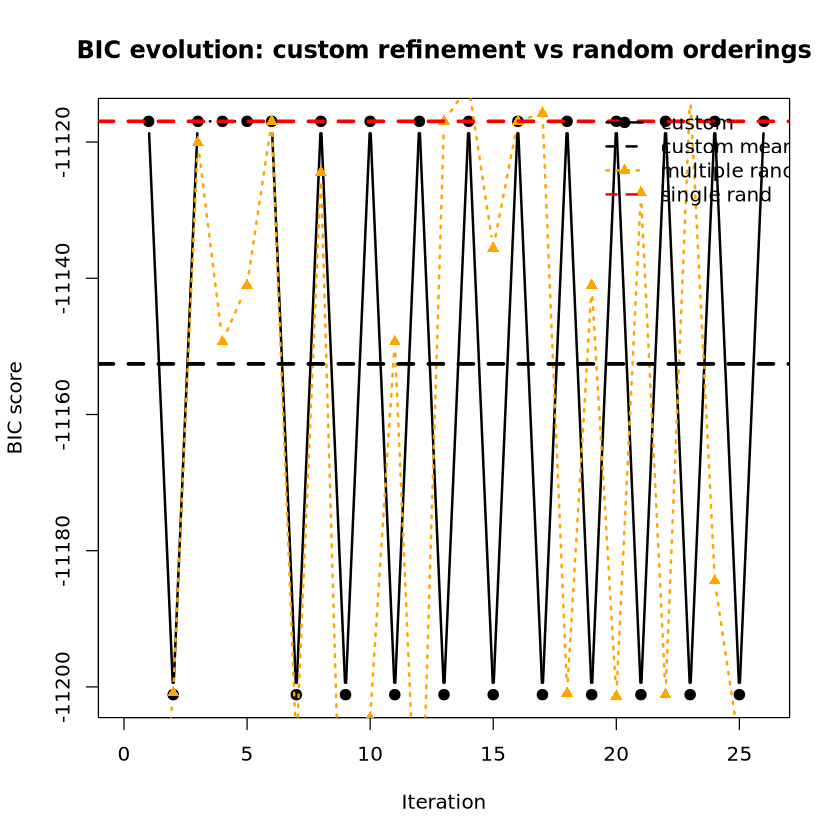

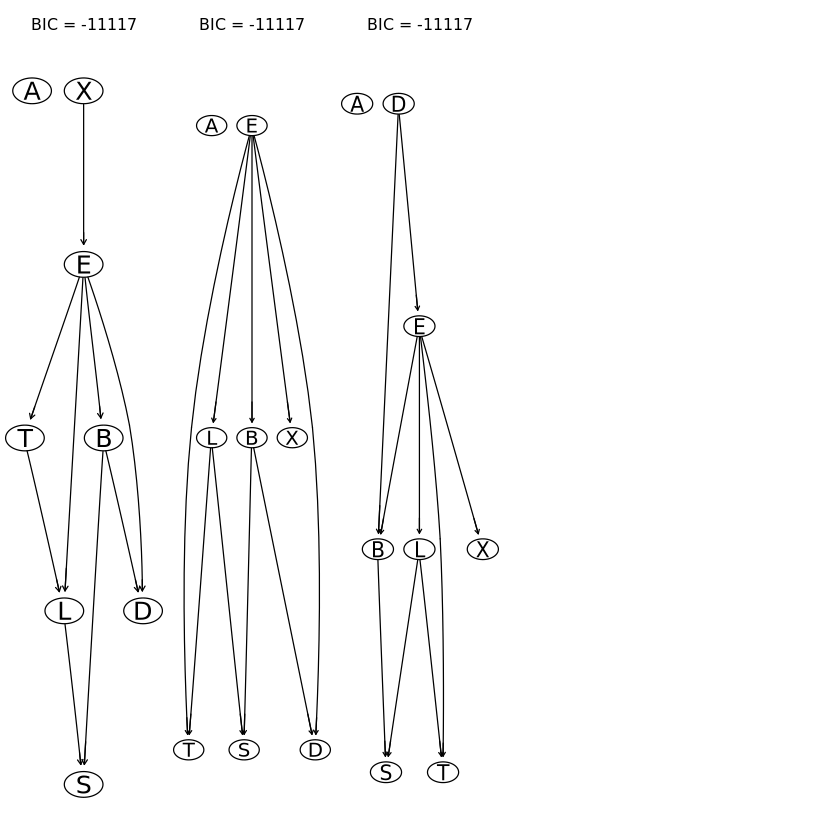

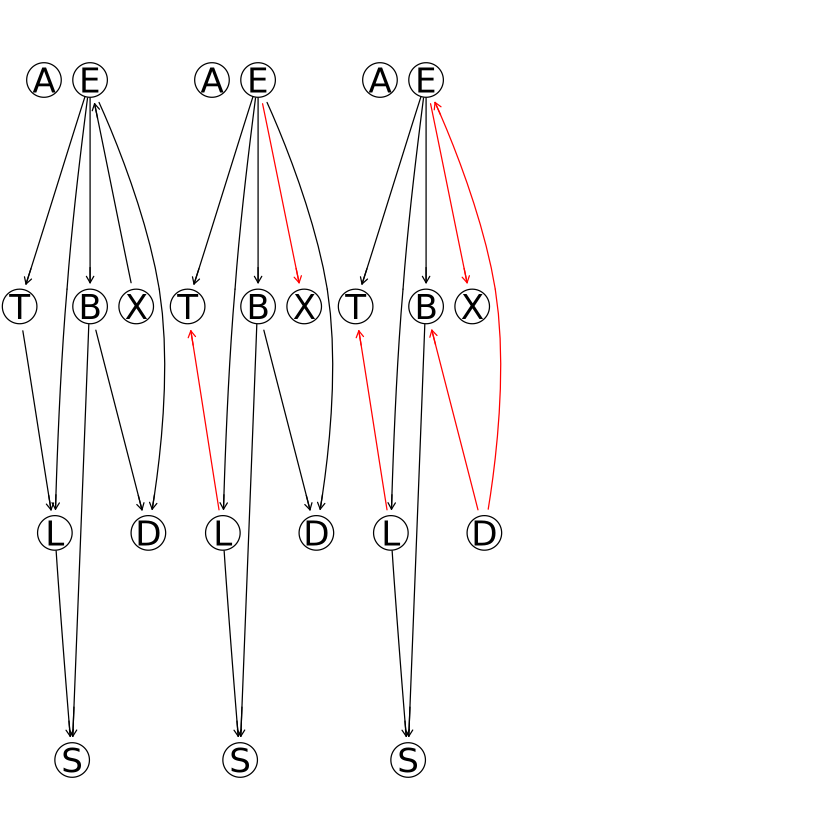

In [29]:
#plotting:
plot_k2_diagnostics(refined_run = refined_run_asia, random_run = random_run, top_k = 3)

The results don't look positive, since the BIC evolution is very unstable, and since node _Asia_ is always disconnected from the network. Let's however try to test the significance of the _Asia_ -> _Tub_ relationship in the _true_ network using a CI test:

In [30]:
ci_asia_tub <- ci.test(x = "A", y = "T", data = data_asia, test = "x2")
print(ci_asia_tub[2])

$p.value
[1] 0.006828901



So the relationship is significative indeed, which confirms the poor quality of the results obtained.


### Grid Search for Structure Learning Evaluation

In this section, we perform a comprehensive grid search over different Bayesian Network structure learning algorithms to compare their performance. This includes evaluating score-based, constraint-based, and hybrid approaches from both the `bnlearn` and `bnstruct` packages.

We assess these methods using:
- **Structural Hamming Distance (SHD)**: Measures the dissimilarity between two network structures.
- **Bayesian Information Criterion (BIC)**: A scoring metric that balances model complexity and fit to data.
- **Execution Time**: Computational cost of learning each structure.

In [4]:
library(bnlearn)
library(bnstruct)
library(Rgraphviz)
library(dplyr)


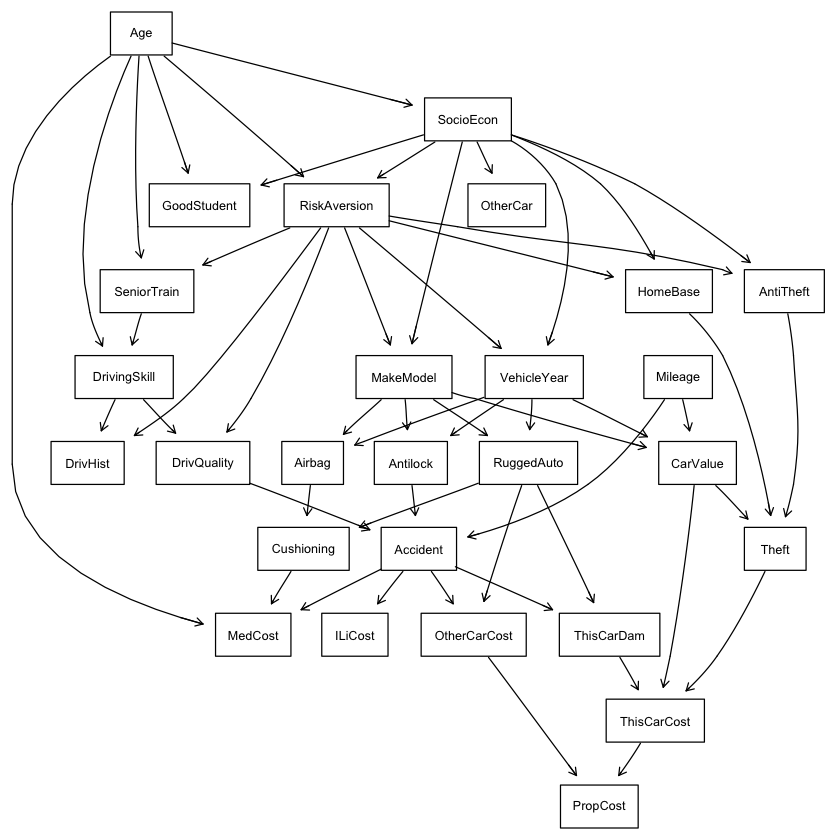

In [20]:
# Data Preparation
download.file(
  "https://www.bnlearn.com/bnrepository/insurance/insurance.net.gz",
  destfile = "insurance.net.gz"
)

if (!require("R.utils")) install.packages("R.utils")

R.utils::gunzip("insurance.net.gz", overwrite = TRUE)
data("insurance")
dat <- insurance
node_names <- names(dat)
dag_true <- bnlearn::read.net("insurance.net")
graphviz.plot(dag_true)
dag_true <- bn.net(dag_true)

### Helper Functions

To ensure consistent evaluation across different Bayesian network libraries, we define two essential helper functions:

#### `custom_shd(predicted, true)`

This function calculates the **Structural Hamming Distance (SHD)** between a predicted and true Directed Acyclic Graph (DAG). SHD measures the number of edge additions, deletions, or reversals required to transform one DAG into another.

- The function first attempts to use the native `shd()` function from the `bnlearn` package.
- If an error occurs (e.g., due to incompatible graph formats), it falls back to a manual comparison:
  - Extracts the set of arcs from both the predicted and true networks.
  - Computes the symmetric difference (set difference in both directions) between these arc sets.
  - Returns the total number of differing arcs as the SHD score.


#### `convert_bnstruct_to_bnlearn(net_bs)`

This utility converts a `bnstruct` DAG object into a format compatible with `bnlearn`:


This conversion is crucial for comparative evaluation, enabling seamless integration of outputs from `bnstruct`-based learners into the `bnlearn` evaluation ecosystem (e.g., for computing SHD or plotting DAGs).


In [21]:
# Helper Functions
custom_shd <- function(predicted, true) {
  tryCatch({
    shd(predicted, true)
  }, error = function(e) {
    # Fallback: arc-level SHD
    true_arcs <- apply(arcs(true), 1, paste, collapse = "~")
    pred_arcs <- apply(arcs(predicted), 1, paste, collapse = "~")
    length(setdiff(true_arcs, pred_arcs)) + length(setdiff(pred_arcs, true_arcs))
  })
}

convert_bnstruct_to_bnlearn <- function(net_bs) {
  adj <- slot(net_bs, "dag")
  nodes <- slot(net_bs, "variables")
  arc_mat <- which(adj != 0, arr.ind = TRUE)
  arc_df <- data.frame(
    from = nodes[arc_mat[, 1]],
    to = nodes[arc_mat[, 2]],
    stringsAsFactors = FALSE
  )
  bn <- empty.graph(nodes)
  arcs(bn) <- as.matrix(arc_df)
  stopifnot(setequal(nodes(bn), nodes(dag_true)))  # sanity check
  return(bn)
}

### Grid Definitions for Structure Learning Evaluation

The algorithms included represent different approaches to structure learning:
- **Score-based methods** (e.g., `hc`, `tabu`) search for network structures that optimize a scoring function.
- **Constraint-based methods** (e.g., `gs`, `iamb`, `mmpc`) use conditional independence tests to construct the network.
- **Hybrid methods** (e.g., `mmhc`) combine both approaches by using constraint-based filtering followed by score-based optimization.

#### Algorithms

- **`hc` (Hill Climbing)**: A greedy local search algorithm that iteratively modifies the network (by adding, deleting, or reversing arcs) to increase a scoring function.
- **`tabu`**: An enhancement of hill climbing that uses a memory structure (tabu list) to avoid cycles and previously visited suboptimal structures.
- **`gs` (Grow-Shrink)**: Constructs the Markov blanket for each variable in two phases—adding relevant variables (grow) and removing conditionally independent ones (shrink).
- **`iamb` (Incremental Association Markov Blanket)**: Selects variables with the highest mutual information iteratively, stopping when additional variables no longer improve the dependency structure.
- **`fast.iamb`**: A faster version of IAMB that prioritizes efficiency in large networks.
- **`inter.iamb`**: Introduces intermediate steps in the grow and shrink phases for greater accuracy and stability.
- **`mmpc` (Max-Min Parents and Children)**: Identifies parents and children of a node by selecting variables with strong associations, followed by conditional independence tests.
- **`mmhc` (Max-Min Hill Climbing)**: A hybrid method that uses MMPC to restrict the search space before applying hill climbing for score optimization.

### Score-Based Grid 

This grid specifies combinations of score-based algorithms and their relevant hyperparameters:

- `algorithm`: `"hc"` or `"tabu"`
- `score`: One of the following:
  - `"k2"` – Likelihood-based score assuming a node ordering.
  - `"bic"` – Penalizes model complexity while maximizing likelihood.
  - `"bde"` – Bayesian Dirichlet equivalent score incorporating priors.
- `maxp`: Maximum allowed number of parents per node.


### Constraint-Based Grid 

This grid defines parameter combinations for constraint-based and hybrid algorithms:

- `algorithm`: One of `"mmhc"`, `"mmpc"`, `"gs"`, `"iamb"`, `"fast.iamb"`, or `"inter.iamb"`
- `test`: Set to `"mi"` (mutual information test).
- `alpha`: Significance level for independence tests, typically one of 0.01, 0.05, 0.1, or 0.2.


In [22]:
# Grid Definitions
score_grid <- expand.grid(
  algorithm = c("hc", "tabu"),
  score = c("k2", "bic", "bde"),
  maxp = c(2, 3, 4),
  test = NA_character_, #not used by score-based methods
  alpha = NA_real_, #not used by score-based methods
  stringsAsFactors = FALSE
)
cb_grid <- expand.grid(
  algorithm = c("mmhc", "mmpc", "mmmb", "gs", "iamb", "fast.iamb", "inter.iamb"),
  score = NA_character_, # not used by constraint-based methods
  maxp = NA_integer_, # not used by constraint-based methods
  test = "mi",
  alpha = c(0.01, 0.05, 0.1, 0.2),
  stringsAsFactors = FALSE
)
algo_grid <- rbind(score_grid, cb_grid)
algo_grid$maxp <- as.integer(algo_grid$maxp)

results <- list()
result_rows_bnlearn <- data.frame(
  method=character(), algorithm=character(), score=character(), maxp=integer(), 
  test=character(), alpha=double(), BIC=numeric(), SHD_REF=integer(), stringsAsFactors=FALSE
)

### Bayesian Network Structure Learning with `bnlearn`

This section implements an automated grid search using the `bnlearn` package to evaluate multiple structure learning algorithms and parameter settings. Each configuration is applied to the dataset, and the resulting models are evaluated using the Bayesian Information Criterion (BIC) and Structural Hamming Distance (SHD) relative to a reference (true) network.

Once all models are evaluated, the algorithm selects the **best model** according to the minimum SHD (i.e., the structure most similar to the ground truth). In cases of ties, the first occurrence is selected.


In [23]:
# bnlearn Search
for (i in seq_len(nrow(algo_grid))) {
  alg <- algo_grid$algorithm[i]
  sc  <- algo_grid$score[i]
  mp  <- algo_grid$maxp[i]
  tst <- algo_grid$test[i]
  a   <- algo_grid$alpha[i]
  
  args <- list(dat)
  if (alg %in% c("hc", "tabu")) {
    args$score <- sc
    args$maxp <- mp
  }
  if (!is.na(tst)) args$test <- tst
  if (!is.na(a)) args$alpha <- a
  
  net <- tryCatch({
    do.call(alg, args)
  }, error=function(e) NULL)
  
  if (!is.null(net)) {
    bic <- tryCatch(score(net, dat, type = "bic"), error = function(e) NA_real_)
    shd_ref <- tryCatch(custom_shd(net, dag_true), error = function(e) NA_integer_)
  } else {
    bic <- NA_real_
    shd_ref <- NA_integer_
  }
  
  result_rows_bnlearn <- rbind(
    result_rows_bnlearn,
    data.frame(
      method="bnlearn", algorithm=alg, score=sc, maxp=mp,
      test=tst, alpha=a, BIC=bic, SHD_REF=shd_ref, stringsAsFactors=FALSE
    )
  )
  key <- paste("bnlearn", alg, sc, mp, tst, a, sep="_")
  results[[key]] <- net
}

cat("Selecting best bnlearn model (min SHD to ground truth)...\n")

best_bnlearn_row <- result_rows_bnlearn %>%
  filter(!is.na(SHD_REF)) %>%
  slice_min(SHD_REF, n = 1)

candidate_keys <- best_bnlearn_row %>%
  transmute(key = paste("bnlearn", algorithm, score, maxp, test, alpha, sep = "_")) %>%
  pull(key)

best_bnlearn_net <- NULL
for (key in candidate_keys) {
  if (!is.null(results[[key]])) {
    best_bnlearn_net <- results[[key]]
    cat("Best model found at key:", key, "\n")
    break
  }
}
if (is.null(best_bnlearn_net)) stop("No valid best bnlearn network found!")

cat("\nBest bnlearn model:\n")
print(best_bnlearn_row)

Warning message in vstruct.apply(arcs = arcs, vs = vs, nodes = nodes, debug = debug):
"vstructure SocioEcon -> RiskAversion <- AntiTheft is not applicable, because one or both arcs are oriented in the opposite direction."
Warning message in vstruct.apply(arcs = arcs, vs = vs, nodes = nodes, debug = debug):
"vstructure MakeModel -> VehicleYear <- Airbag is not applicable, because one or both arcs are oriented in the opposite direction."
Warning message in vstruct.apply(arcs = arcs, vs = vs, nodes = nodes, debug = debug):
"vstructure VehicleYear -> Airbag <- RuggedAuto is not applicable, because one or both arcs are oriented in the opposite direction."
Warning message in vstruct.apply(arcs = arcs, vs = vs, nodes = nodes, debug = debug):
"vstructure DrivQuality -> RiskAversion <- SeniorTrain is not applicable, because one or both arcs are oriented in the opposite direction."
Warning message in vstruct.apply(arcs = arcs, vs = vs, nodes = nodes, debug = debug):
"vstructure VehicleYear -> Ma

Selecting best bnlearn model (min SHD to ground truth)...
Best model found at key: bnlearn_tabu_bde_3_NA_NA 

Best bnlearn model:
   method algorithm score maxp test alpha     BIC SHD_REF
1 bnlearn      tabu   bde    3 <NA>    NA -265567      32
2 bnlearn      tabu   bde    4 <NA>    NA -265567      32


### Structure Learning with `bnstruct`

In this section, we perform a grid search using the `bnstruct` package to evaluate structure learning algorithms over different scoring functions and maximum parent settings. Unlike `bnlearn`, which accepts data in data frame form, `bnstruct` requires a specialized `BNDataset` object, so we preprocess the input accordingly.

#### Preprocessing

- The original dataset is converted to integer-encoded factors, and then to a matrix for compatibility with `bnstruct`.
- A `BNDataset` object is initialized by manually setting its internal slots (e.g., raw data, discreteness, variable names, and node sizes).

This configuration yielded the most accurate structure in terms of SHD, outperforming the best `bnlearn` result (SHD = 32).


The `bnstruct`-based approach—particularly using `mmhc` with `BDeu` and moderate complexity—demonstrates strong structural recovery capabilities. The lower SHD value indicates that the learned structure closely aligns with the reference DAG, supporting the utility of `bnstruct` in accurate structure estimation under these settings.


In [24]:
# bnstruct Search 
cat("Running updated grid search for bnstruct (hc + mmhc)...\n")

data_int <- data.frame(lapply(dat, function(x) as.integer(as.factor(x))))
data_matrix <- as.matrix(data_int)

bnstruct_grid <- expand.grid(
  algorithm = c("hc", "mmhc"),
  score = c("BDeu", "BIC"),
  maxp = c(2, 3, 4),
  stringsAsFactors = FALSE
)

result_rows_bnstruct <- data.frame(
  method = character(), algorithm = character(), score = character(),
  maxp = integer(), BIC = numeric(), SHD_REF = integer(), stringsAsFactors = FALSE
)

for (i in seq_len(nrow(bnstruct_grid))) {
  alg <- bnstruct_grid$algorithm[i]
  sc  <- bnstruct_grid$score[i]
  mp  <- bnstruct_grid$maxp[i]
  
  cat(sprintf(">>> Running bnstruct: algorithm = %s | score = %s | maxp = %d\n", alg, sc, mp))
  
  bndata <- methods::new("BNDataset")
  slot(bndata, "raw.data")      <- as.matrix(data_int)
  slot(bndata, "discreteness")  <- rep(TRUE, ncol(data_int))
  slot(bndata, "variables")     <- colnames(data_int)
  slot(bndata, "node.sizes")    <- apply(data_int, 2, max, na.rm = TRUE) + 1
  slot(bndata, "num.variables") <- ncol(data_int)
  slot(bndata, "has.raw.data")  <- TRUE
  
  net_bs <- tryCatch({
    learn.network(
      x = bndata,
      algo = alg,
      scoring.func = sc,
      max.fanin = mp,
      max.parents = mp
    )
  }, error = function(e) {
    cat(sprintf("!!! Error in learn.network: %s\n", e$message))
    NULL
  })
  
  if (is.null(net_bs)) next
  
  net_bn <- tryCatch({
    convert_bnstruct_to_bnlearn(net_bs)
  }, error = function(e) {
    cat(sprintf("!!! Error in manual conversion: %s\n", e$message))
    NULL
  })
  
  if (is.null(net_bn)) next
  
  bic_bs <- tryCatch(score(net_bn, dat, type = "bic"), error = function(e) NA_real_)
  shd_bs <- tryCatch(custom_shd(net_bn, dag_true), error = function(e) NA_integer_)
  
  cat(sprintf("Stored result: %s | %s | maxp=%d | BIC=%.2f | SHD_REF=%d\n",
              alg, sc, mp, bic_bs, shd_bs))
  
  result_rows_bnstruct <- rbind(
    result_rows_bnstruct,
    data.frame(
      method = "bnstruct",
      algorithm = alg,
      score = sc,
      maxp = mp,
      BIC = bic_bs,
      SHD_REF = shd_bs,
      stringsAsFactors = FALSE
    )
  )
  
  key <- paste("bnstruct", alg, sc, mp, sep = "_")
  results[[key]] <- net_bn
}

cat("\nBest bnstruct network (min SHD to ground truth):\n")
best_bnstruct_row <- result_rows_bnstruct %>%
  filter(!is.na(SHD_REF)) %>%
  slice_min(SHD_REF, n = 1)

if (nrow(best_bnstruct_row) > 0) {
  best_key <- paste("bnstruct",
                    best_bnstruct_row$algorithm[1],
                    best_bnstruct_row$score[1],
                    best_bnstruct_row$maxp[1],
                    sep = "_")
  best_bnstruct_net <- results[[best_key]]
} else {
  best_bnstruct_net <- NULL
}

print(best_bnstruct_row)

Running updated grid search for bnstruct (hc + mmhc)...
>>> Running bnstruct: algorithm = hc | score = BDeu | maxp = 2


bnstruct :: learning the structure using HC ...

bnstruct :: learning using HC completed.

bnstruct :: learning network parameters ... 

Warning message in validityMethod(object):
" Not all of the possible values have been observed for variables  1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27"
bnstruct :: parameter learning done.



Stored result: hc | BDeu | maxp=2 | BIC=-267287.26 | SHD_REF=45
>>> Running bnstruct: algorithm = mmhc | score = BDeu | maxp = 2


bnstruct :: learning the structure using MMHC ...

bnstruct :: learning using MMHC completed.

bnstruct :: learning network parameters ... 

Warning message in validityMethod(object):
" Not all of the possible values have been observed for variables  1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27"
bnstruct :: parameter learning done.



Stored result: mmhc | BDeu | maxp=2 | BIC=-269105.18 | SHD_REF=29
>>> Running bnstruct: algorithm = hc | score = BIC | maxp = 2


bnstruct :: learning the structure using HC ...

bnstruct :: learning using HC completed.

bnstruct :: learning network parameters ... 

Warning message in validityMethod(object):
" Not all of the possible values have been observed for variables  1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27"
bnstruct :: parameter learning done.



Stored result: hc | BIC | maxp=2 | BIC=-276296.55 | SHD_REF=59
>>> Running bnstruct: algorithm = mmhc | score = BIC | maxp = 2


bnstruct :: learning the structure using MMHC ...

bnstruct :: learning using MMHC completed.

bnstruct :: learning network parameters ... 

Warning message in validityMethod(object):
" Not all of the possible values have been observed for variables  1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27"
bnstruct :: parameter learning done.



Stored result: mmhc | BIC | maxp=2 | BIC=-275660.60 | SHD_REF=44
>>> Running bnstruct: algorithm = hc | score = BDeu | maxp = 3


bnstruct :: learning the structure using HC ...

bnstruct :: learning using HC completed.

bnstruct :: learning network parameters ... 

Warning message in validityMethod(object):
" Not all of the possible values have been observed for variables  1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27"
bnstruct :: parameter learning done.



Stored result: hc | BDeu | maxp=3 | BIC=-265724.60 | SHD_REF=30
>>> Running bnstruct: algorithm = mmhc | score = BDeu | maxp = 3


bnstruct :: learning the structure using MMHC ...

bnstruct :: learning using MMHC completed.

bnstruct :: learning network parameters ... 

Warning message in validityMethod(object):
" Not all of the possible values have been observed for variables  1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27"
bnstruct :: parameter learning done.



Stored result: mmhc | BDeu | maxp=3 | BIC=-266257.98 | SHD_REF=21
>>> Running bnstruct: algorithm = hc | score = BIC | maxp = 3


bnstruct :: learning the structure using HC ...

bnstruct :: learning using HC completed.

bnstruct :: learning network parameters ... 

Warning message in validityMethod(object):
" Not all of the possible values have been observed for variables  1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27"
bnstruct :: parameter learning done.



Stored result: hc | BIC | maxp=3 | BIC=-268670.00 | SHD_REF=59
>>> Running bnstruct: algorithm = mmhc | score = BIC | maxp = 3


bnstruct :: learning the structure using MMHC ...

bnstruct :: learning using MMHC completed.

bnstruct :: learning network parameters ... 

Warning message in validityMethod(object):
" Not all of the possible values have been observed for variables  1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27"
bnstruct :: parameter learning done.



Stored result: mmhc | BIC | maxp=3 | BIC=-275588.25 | SHD_REF=47
>>> Running bnstruct: algorithm = hc | score = BDeu | maxp = 4


bnstruct :: learning the structure using HC ...

bnstruct :: learning using HC completed.

bnstruct :: learning network parameters ... 

Warning message in validityMethod(object):
" Not all of the possible values have been observed for variables  1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27"
bnstruct :: parameter learning done.



Stored result: hc | BDeu | maxp=4 | BIC=-265724.60 | SHD_REF=30
>>> Running bnstruct: algorithm = mmhc | score = BDeu | maxp = 4


bnstruct :: learning the structure using MMHC ...

bnstruct :: learning using MMHC completed.

bnstruct :: learning network parameters ... 

Warning message in validityMethod(object):
" Not all of the possible values have been observed for variables  1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27"
bnstruct :: parameter learning done.



Stored result: mmhc | BDeu | maxp=4 | BIC=-266257.98 | SHD_REF=21
>>> Running bnstruct: algorithm = hc | score = BIC | maxp = 4


bnstruct :: learning the structure using HC ...

bnstruct :: learning using HC completed.

bnstruct :: learning network parameters ... 

Warning message in validityMethod(object):
" Not all of the possible values have been observed for variables  1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27"
bnstruct :: parameter learning done.



Stored result: hc | BIC | maxp=4 | BIC=-268670.00 | SHD_REF=59
>>> Running bnstruct: algorithm = mmhc | score = BIC | maxp = 4


bnstruct :: learning the structure using MMHC ...

bnstruct :: learning using MMHC completed.

bnstruct :: learning network parameters ... 

Warning message in validityMethod(object):
" Not all of the possible values have been observed for variables  1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27"
bnstruct :: parameter learning done.



Stored result: mmhc | BIC | maxp=4 | BIC=-275588.25 | SHD_REF=47

Best bnstruct network (min SHD to ground truth):
    method algorithm score maxp     BIC SHD_REF
1 bnstruct      mmhc  BDeu    3 -266258      21
2 bnstruct      mmhc  BDeu    4 -266258      21



Visual comparison of best models:


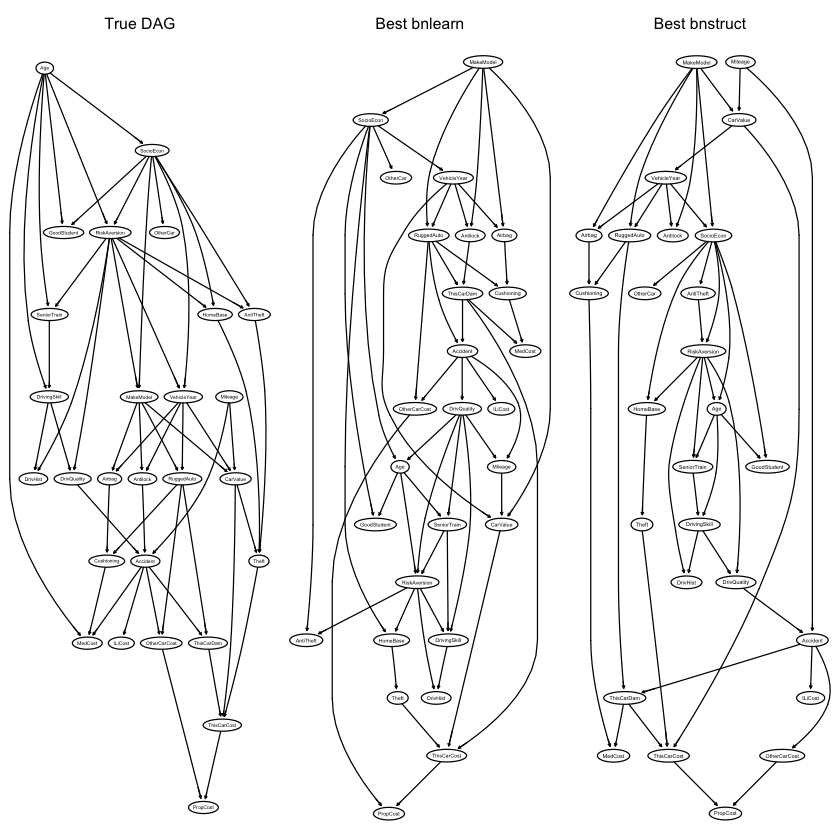

In [25]:
# Visual & Quantitative Comparison
cat("\nVisual comparison of best models:\n")
par(mfrow=c(1,3))
graphviz.plot(dag_true, main="True DAG", shape="ellipse")
graphviz.plot(best_bnlearn_net, main="Best bnlearn", shape="ellipse")
graphviz.plot(best_bnstruct_net, main="Best bnstruct", shape="ellipse")
par(mfrow=c(1,1))

### Interpretation

- **Black arrows**: Correctly recovered arcs.
- **Red arrows**: Extra arcs present in the learned model but absent in the true DAG.
- **Blue dashed arrows**: Arcs missing from the learned model that were present in the ground truth.

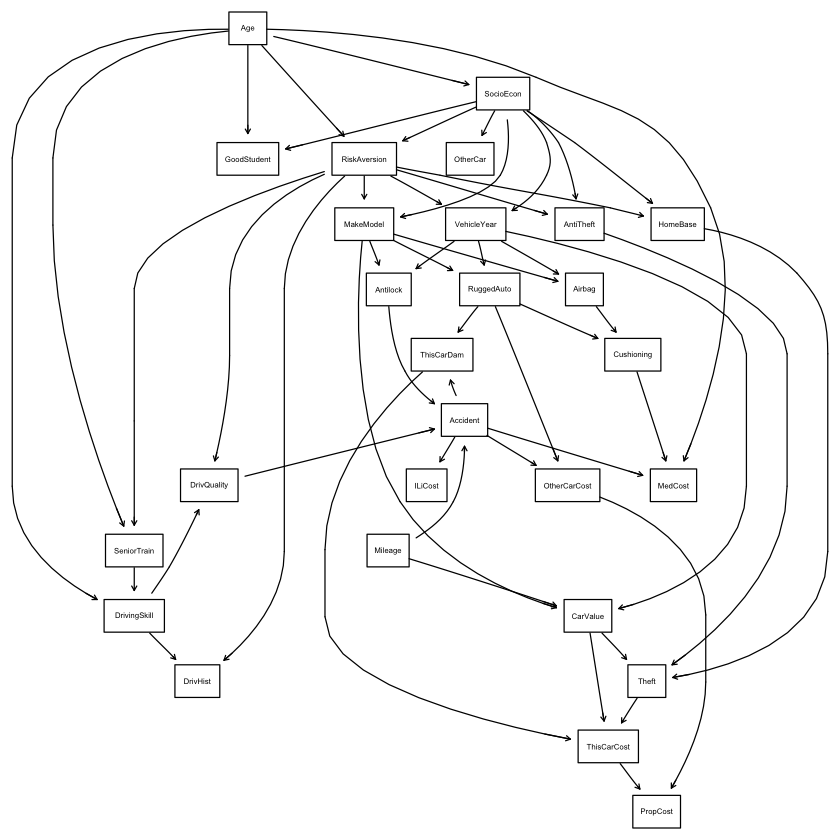

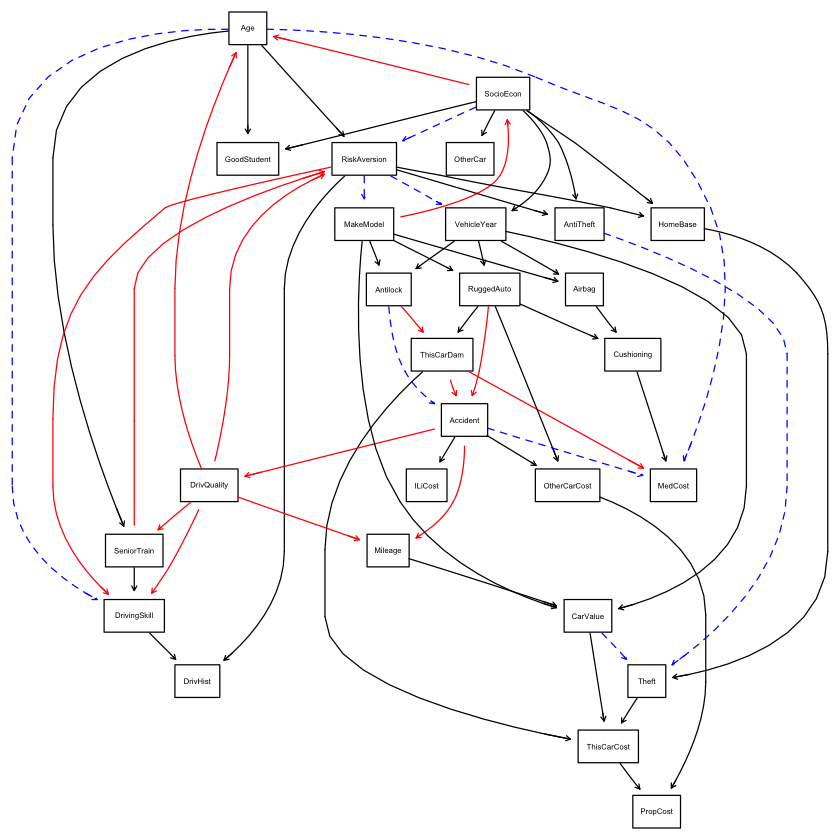

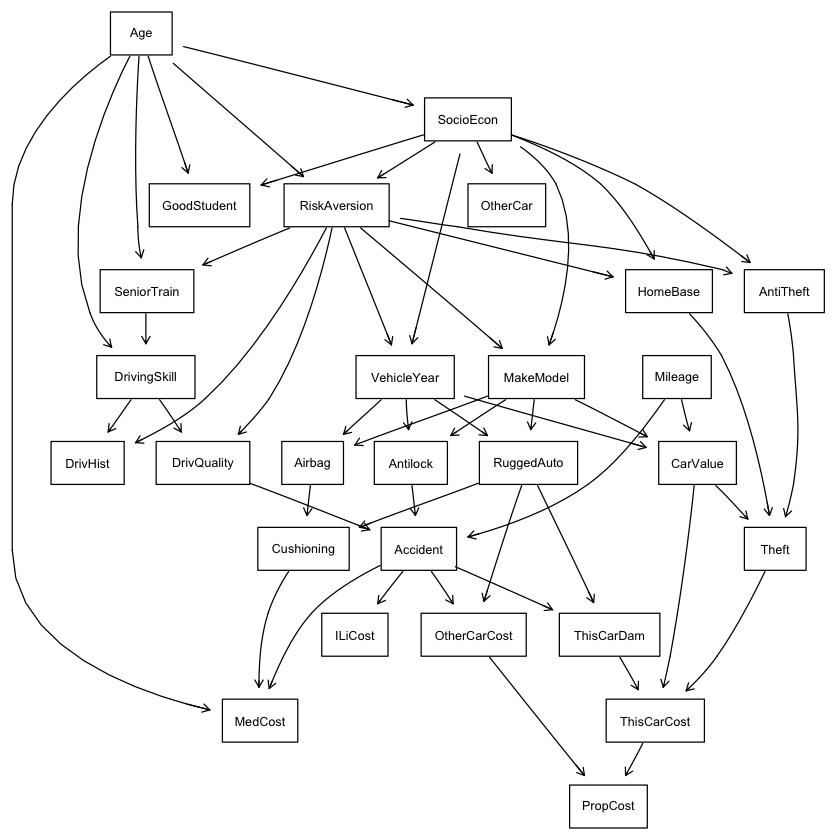

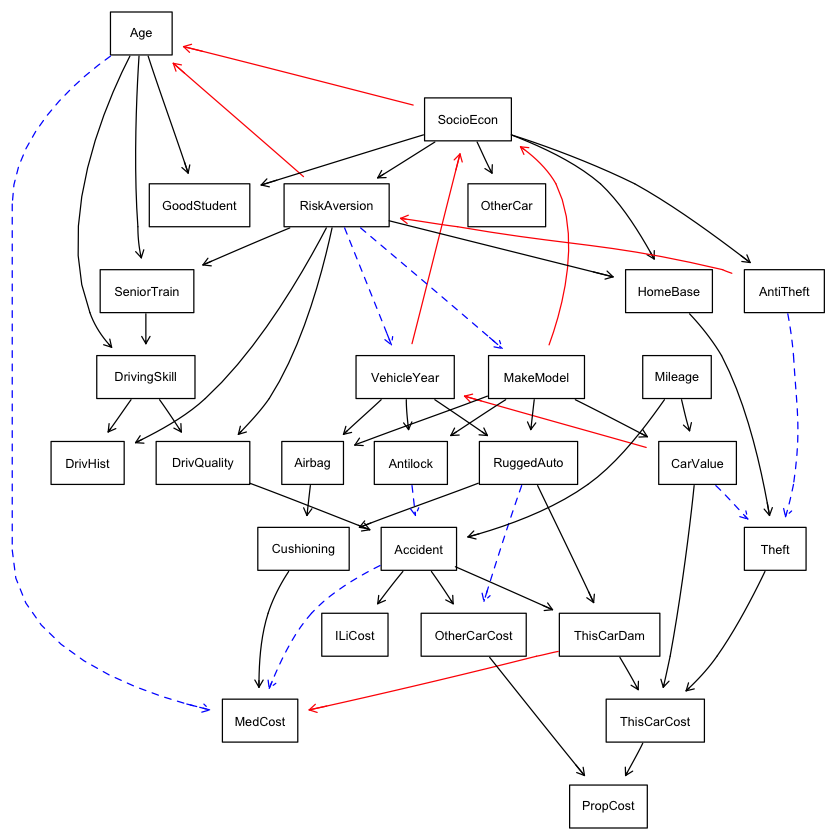

In [26]:
# Comparison plots
graphviz.compare(dag_true, best_bnlearn_net)
graphviz.compare(dag_true, best_bnstruct_net)


In [27]:
# Final Summary
result_rows_all <- bind_rows(result_rows_bnlearn, result_rows_bnstruct)

cat("\n==== Full Summary Table ====\n")
summary_table <- result_rows_all %>%
  arrange(SHD_REF, BIC) %>%
  select(Method = method, Algorithm = algorithm, Score = score, MaxParents = maxp,
         Test = test, Alpha = alpha, BIC, SHD = SHD_REF)
print(summary_table, row.names = FALSE)


==== Full Summary Table ====
   Method  Algorithm Score MaxParents Test Alpha       BIC SHD
 bnstruct       mmhc  BDeu          3 <NA>    NA -266258.0  21
 bnstruct       mmhc  BDeu          4 <NA>    NA -266258.0  21
 bnstruct       mmhc  BDeu          2 <NA>    NA -269105.2  29
 bnstruct         hc  BDeu          3 <NA>    NA -265724.6  30
 bnstruct         hc  BDeu          4 <NA>    NA -265724.6  30
  bnlearn       tabu   bde          3 <NA>    NA -265567.0  32
  bnlearn       tabu   bde          4 <NA>    NA -265567.0  32
  bnlearn       tabu   bde          2 <NA>    NA -267313.7  36
  bnlearn         hc    k2          4 <NA>    NA -266665.3  40
  bnlearn       tabu    k2          4 <NA>    NA -266665.3  40
  bnlearn         hc   bde          3 <NA>    NA -265700.7  40
  bnlearn         hc   bde          4 <NA>    NA -265700.7  40
  bnlearn  fast.iamb  <NA>         NA   mi  0.01        NA  41
  bnlearn         hc    k2          2 <NA>    NA -268436.0  42
  bnlearn       tabu    k

Selecting best bnlearn model (min SHD to ground truth)...
Best model found at key: bnlearn_hc_bic_2_NA_NA 

Best bnlearn model:
    method algorithm score maxp test alpha BIC SHD_REF
1  bnlearn        hc   bic    2 <NA>    NA  NA       7
2  bnlearn      tabu   bic    2 <NA>    NA  NA       7
3  bnlearn        hc   bde    2 <NA>    NA  NA       7
4  bnlearn      tabu   bde    2 <NA>    NA  NA       7
5  bnlearn        hc   bic    3 <NA>    NA  NA       7
6  bnlearn      tabu   bic    3 <NA>    NA  NA       7
7  bnlearn        hc   bde    3 <NA>    NA  NA       7
8  bnlearn      tabu   bde    3 <NA>    NA  NA       7
9  bnlearn        hc   bic    4 <NA>    NA  NA       7
10 bnlearn      tabu   bic    4 <NA>    NA  NA       7
11 bnlearn        hc   bde    4 <NA>    NA  NA       7
12 bnlearn      tabu   bde    4 <NA>    NA  NA       7
Running updated grid search for bnstruct (hc + mmhc)...
>>> Running bnstruct: algorithm = hc | score = BDeu | maxp = 2


bnstruct :: learning the structure using HC ...

bnstruct :: learning using HC completed.

bnstruct :: learning network parameters ... 

Warning message in validityMethod(object):
" Not all of the possible values have been observed for variables  1 2 3 4 5 6 7 8"
bnstruct :: parameter learning done.



Stored result: hc | BDeu | maxp=2 | BIC=NA | SHD_REF=8
>>> Running bnstruct: algorithm = mmhc | score = BDeu | maxp = 2


bnstruct :: learning the structure using MMHC ...

bnstruct :: learning using MMHC completed.

bnstruct :: learning network parameters ... 

Warning message in validityMethod(object):
" Not all of the possible values have been observed for variables  1 2 3 4 5 6 7 8"
bnstruct :: parameter learning done.



Stored result: mmhc | BDeu | maxp=2 | BIC=NA | SHD_REF=11
>>> Running bnstruct: algorithm = hc | score = BIC | maxp = 2


bnstruct :: learning the structure using HC ...

bnstruct :: learning using HC completed.

bnstruct :: learning network parameters ... 

Warning message in validityMethod(object):
" Not all of the possible values have been observed for variables  1 2 3 4 5 6 7 8"
bnstruct :: parameter learning done.



Stored result: hc | BIC | maxp=2 | BIC=NA | SHD_REF=11
>>> Running bnstruct: algorithm = mmhc | score = BIC | maxp = 2


bnstruct :: learning the structure using MMHC ...

bnstruct :: learning using MMHC completed.

bnstruct :: learning network parameters ... 

Warning message in validityMethod(object):
" Not all of the possible values have been observed for variables  1 2 3 4 5 6 7 8"
bnstruct :: parameter learning done.



Stored result: mmhc | BIC | maxp=2 | BIC=NA | SHD_REF=11
>>> Running bnstruct: algorithm = hc | score = BDeu | maxp = 3


bnstruct :: learning the structure using HC ...

bnstruct :: learning using HC completed.

bnstruct :: learning network parameters ... 

Warning message in validityMethod(object):
" Not all of the possible values have been observed for variables  1 2 3 4 5 6 7 8"
bnstruct :: parameter learning done.



Stored result: hc | BDeu | maxp=3 | BIC=NA | SHD_REF=11
>>> Running bnstruct: algorithm = mmhc | score = BDeu | maxp = 3


bnstruct :: learning the structure using MMHC ...

bnstruct :: learning using MMHC completed.

bnstruct :: learning network parameters ... 

Warning message in validityMethod(object):
" Not all of the possible values have been observed for variables  1 2 3 4 5 6 7 8"
bnstruct :: parameter learning done.



Stored result: mmhc | BDeu | maxp=3 | BIC=NA | SHD_REF=11
>>> Running bnstruct: algorithm = hc | score = BIC | maxp = 3


bnstruct :: learning the structure using HC ...

bnstruct :: learning using HC completed.

bnstruct :: learning network parameters ... 

Warning message in validityMethod(object):
" Not all of the possible values have been observed for variables  1 2 3 4 5 6 7 8"
bnstruct :: parameter learning done.



Stored result: hc | BIC | maxp=3 | BIC=NA | SHD_REF=11
>>> Running bnstruct: algorithm = mmhc | score = BIC | maxp = 3


bnstruct :: learning the structure using MMHC ...

bnstruct :: learning using MMHC completed.

bnstruct :: learning network parameters ... 

Warning message in validityMethod(object):
" Not all of the possible values have been observed for variables  1 2 3 4 5 6 7 8"
bnstruct :: parameter learning done.



Stored result: mmhc | BIC | maxp=3 | BIC=NA | SHD_REF=11
>>> Running bnstruct: algorithm = hc | score = BDeu | maxp = 4


bnstruct :: learning the structure using HC ...

bnstruct :: learning using HC completed.

bnstruct :: learning network parameters ... 

Warning message in validityMethod(object):
" Not all of the possible values have been observed for variables  1 2 3 4 5 6 7 8"
bnstruct :: parameter learning done.



Stored result: hc | BDeu | maxp=4 | BIC=NA | SHD_REF=11
>>> Running bnstruct: algorithm = mmhc | score = BDeu | maxp = 4


bnstruct :: learning the structure using MMHC ...

bnstruct :: learning using MMHC completed.

bnstruct :: learning network parameters ... 

Warning message in validityMethod(object):
" Not all of the possible values have been observed for variables  1 2 3 4 5 6 7 8"
bnstruct :: parameter learning done.



Stored result: mmhc | BDeu | maxp=4 | BIC=NA | SHD_REF=11
>>> Running bnstruct: algorithm = hc | score = BIC | maxp = 4


bnstruct :: learning the structure using HC ...

bnstruct :: learning using HC completed.

bnstruct :: learning network parameters ... 

Warning message in validityMethod(object):
" Not all of the possible values have been observed for variables  1 2 3 4 5 6 7 8"
bnstruct :: parameter learning done.



Stored result: hc | BIC | maxp=4 | BIC=NA | SHD_REF=11
>>> Running bnstruct: algorithm = mmhc | score = BIC | maxp = 4


bnstruct :: learning the structure using MMHC ...

bnstruct :: learning using MMHC completed.

bnstruct :: learning network parameters ... 

Warning message in validityMethod(object):
" Not all of the possible values have been observed for variables  1 2 3 4 5 6 7 8"
bnstruct :: parameter learning done.



Stored result: mmhc | BIC | maxp=4 | BIC=NA | SHD_REF=11

Best bnstruct network (min SHD to ground truth):
    method algorithm score maxp BIC SHD_REF
1 bnstruct        hc  BDeu    2  NA       8

Visual comparison of best models:


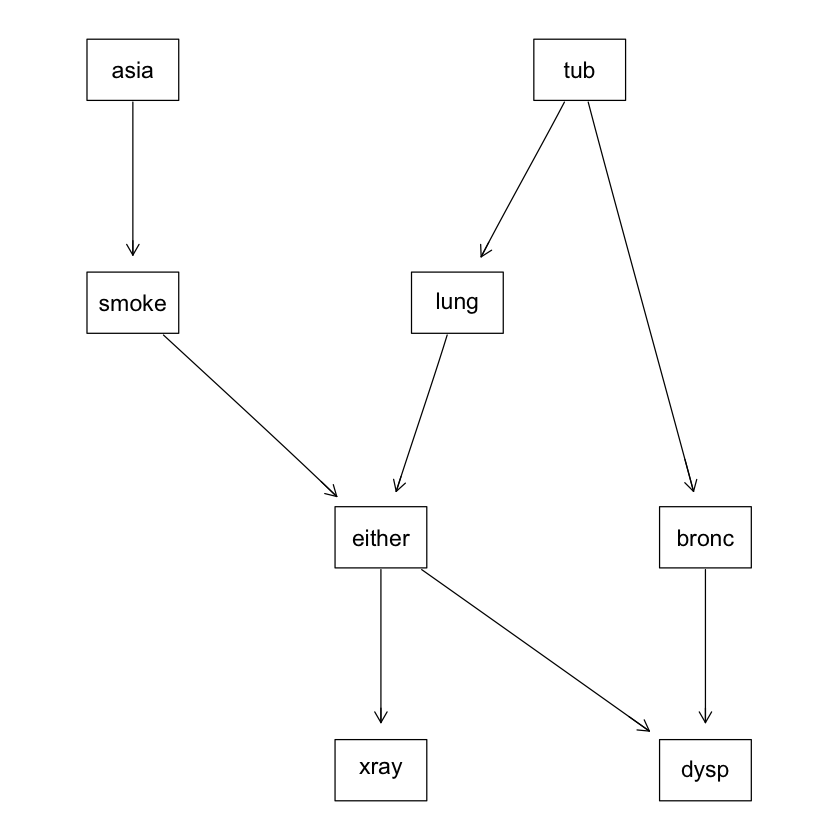

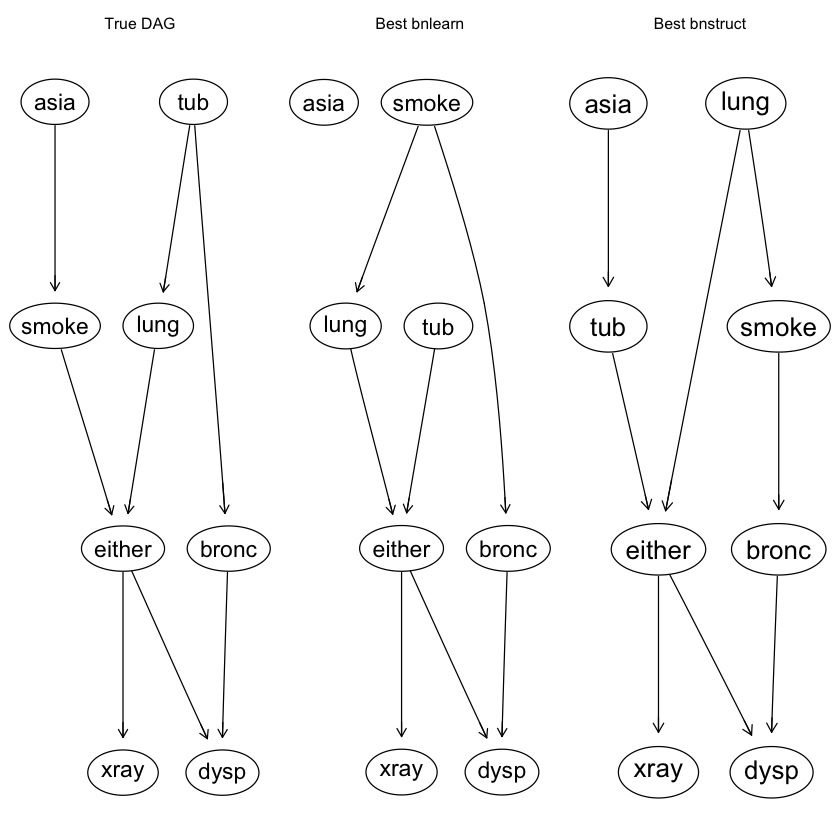

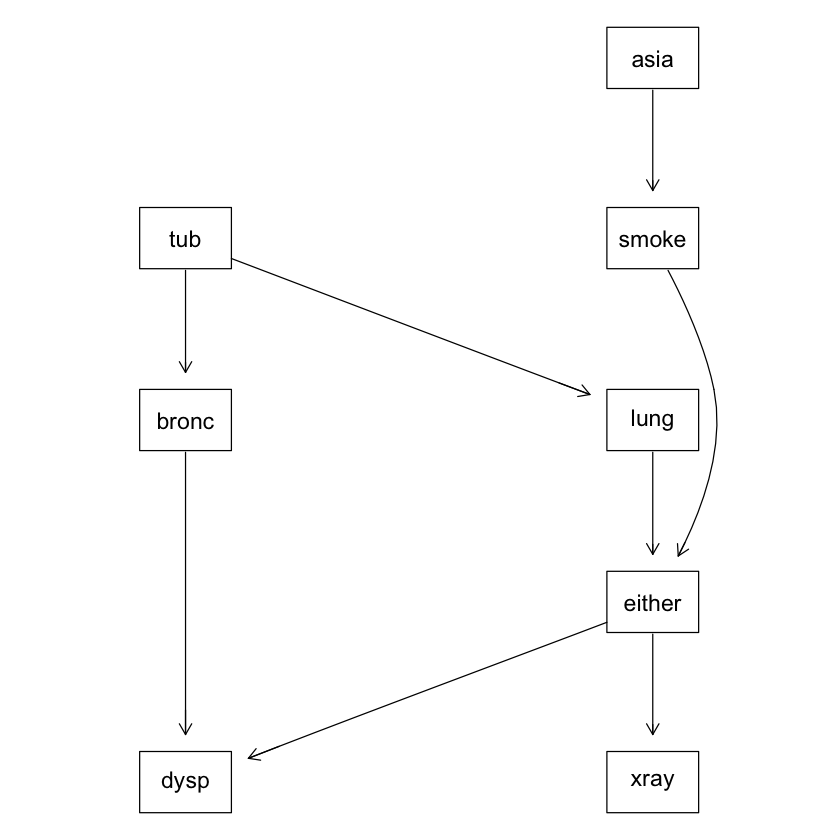

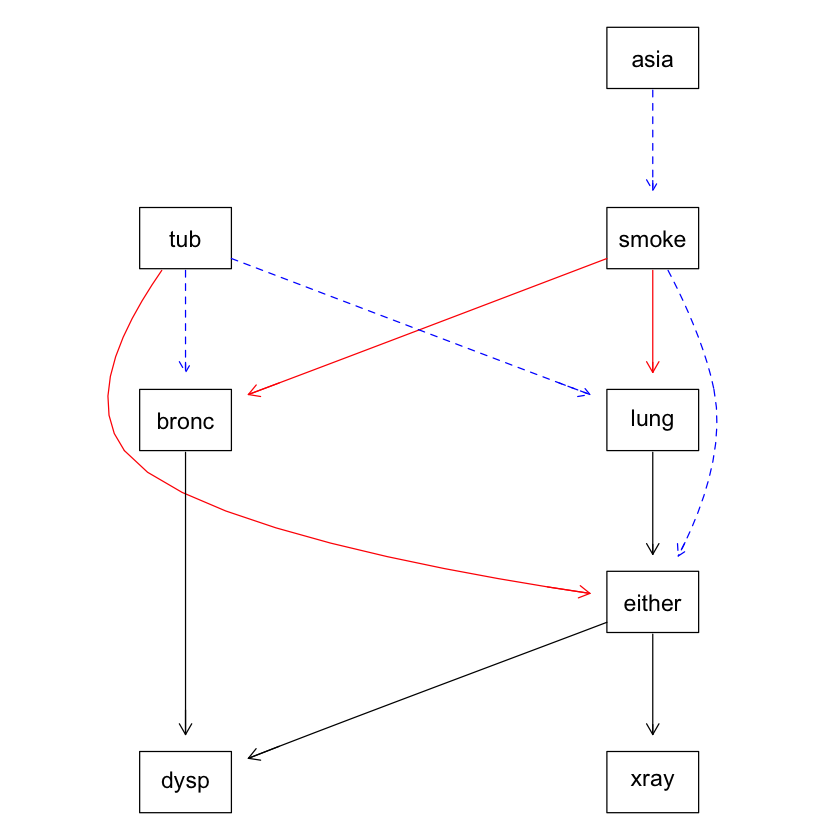

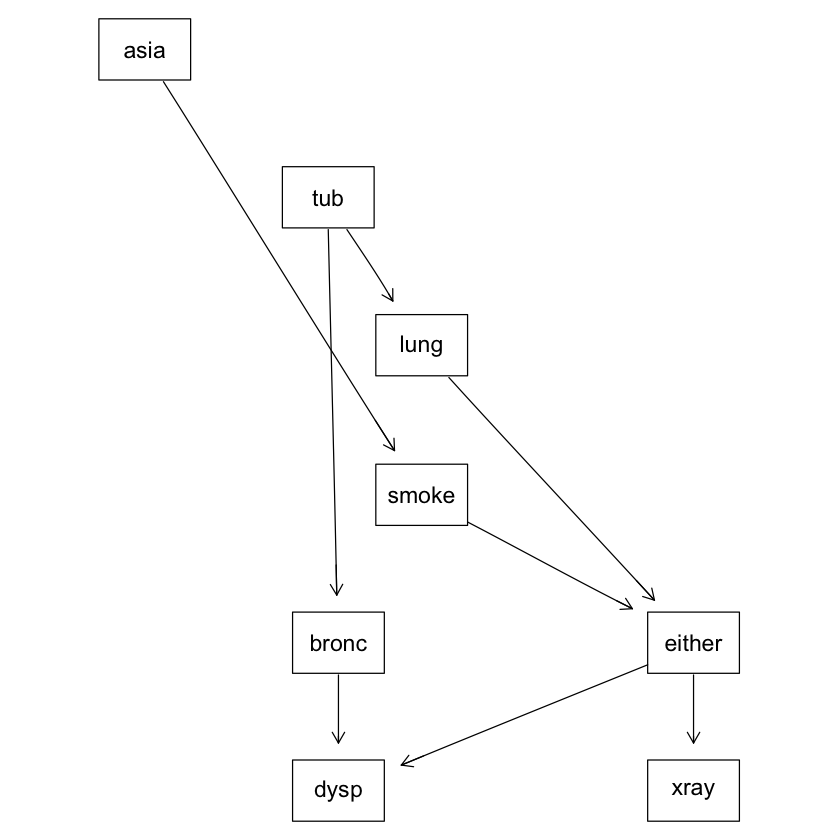


==== Full Summary Table ====
   Method  Algorithm Score MaxParents Test Alpha BIC SHD
  bnlearn         hc   bic          2 <NA>    NA  NA   7
  bnlearn       tabu   bic          2 <NA>    NA  NA   7
  bnlearn         hc   bde          2 <NA>    NA  NA   7
  bnlearn       tabu   bde          2 <NA>    NA  NA   7
  bnlearn         hc   bic          3 <NA>    NA  NA   7
  bnlearn       tabu   bic          3 <NA>    NA  NA   7
  bnlearn         hc   bde          3 <NA>    NA  NA   7
  bnlearn       tabu   bde          3 <NA>    NA  NA   7
  bnlearn         hc   bic          4 <NA>    NA  NA   7
  bnlearn       tabu   bic          4 <NA>    NA  NA   7
  bnlearn         hc   bde          4 <NA>    NA  NA   7
  bnlearn       tabu   bde          4 <NA>    NA  NA   7
 bnstruct         hc  BDeu          2 <NA>    NA  NA   8
  bnlearn       tabu    k2          3 <NA>    NA  NA  10
  bnlearn         gs  <NA>         NA   mi  0.01  NA  10
  bnlearn       iamb  <NA>         NA   mi  0.01  NA  10
 

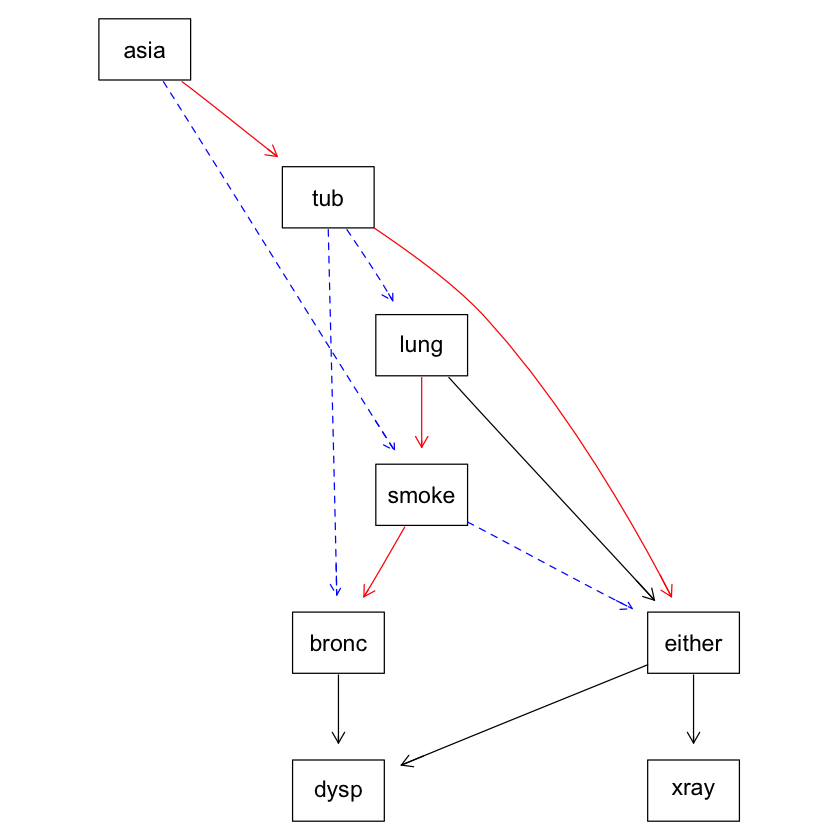

In [29]:
library(bnlearn)
library(bnstruct)
library(Rgraphviz)
library(dplyr)

# ------------------- #
# Data Preparation
download.file(
  "https://www.bnlearn.com/bnrepository/asia/asia.net.gz",
  destfile = "asia.net.gz"
)

if (!require("R.utils")) install.packages("R.utils")

R.utils::gunzip("asia.net.gz", overwrite = TRUE)
data("asia")
dat <- asia
node_names <- names(dat)
dag_true <- bnlearn::read.net("asia.net")
node_map <- c(
  A = "asia", S = "smoke", T = "tub", L = "lung",
  B = "bronc", E = "either", X = "xray", D = "dysp"
)
dag_true <- bnlearn::rename.nodes(dag_true, node_map)
graphviz.plot(dag_true)
dag_true <- bn.net(dag_true)

# ------------------- #
# Helper Functions
custom_shd <- function(predicted, true) {
  tryCatch({
    shd(predicted, true)
  }, error = function(e) {
    # Fallback: arc-level SHD
    true_arcs <- apply(arcs(true), 1, paste, collapse = "~")
    pred_arcs <- apply(arcs(predicted), 1, paste, collapse = "~")
    length(setdiff(true_arcs, pred_arcs)) + length(setdiff(pred_arcs, true_arcs))
  })
}

convert_bnstruct_to_bnlearn <- function(net_bs, dag_true) {
    adj <- slot(net_bs, "dag")
    internal_names <- slot(net_bs, "variables")  # e.g., A, S, T, etc.
    true_names <- nodes(dag_true)                # e.g., "asia", "tub", ...

    if (length(internal_names) != length(true_names)) {
        cat(" Length mismatch in node lists.\n")
        return(NULL)
    }

    # Create name map: "A" -> "asia", "S" -> "tub", etc.
    name_map <- setNames(true_names, internal_names)

    arc_mat <- which(adj != 0, arr.ind = TRUE)
    arc_df <- data.frame(
        from = name_map[internal_names[arc_mat[, 1]]],
        to   = name_map[internal_names[arc_mat[, 2]]],
        stringsAsFactors = FALSE
    )

    bn <- empty.graph(true_names)
    arcs(bn) <- as.matrix(arc_df)

    return(bn)
}



# ------------------- #
# Grid Definitions
score_grid <- expand.grid(
  algorithm = c("hc", "tabu"),
  score = c("k2", "bic", "bde"),
  maxp = c(2, 3, 4),
  test = NA_character_,
  alpha = NA_real_,
  stringsAsFactors = FALSE
)
cb_grid <- expand.grid(
  algorithm = c("mmhc", "mmpc", "mmmb", "gs", "iamb", "fast.iamb", "inter.iamb"),
  score = NA_character_,
  maxp = NA_integer_,
  test = "mi",
  alpha = c(0.01, 0.05, 0.1, 0.2),
  stringsAsFactors = FALSE
)
algo_grid <- rbind(score_grid, cb_grid)
algo_grid$maxp <- as.integer(algo_grid$maxp)

results <- list()
result_rows_bnlearn <- data.frame(
  method=character(), algorithm=character(), score=character(), maxp=integer(), 
  test=character(), alpha=double(), BIC=numeric(), SHD_REF=integer(), stringsAsFactors=FALSE
)

# ------------------- #
# bnlearn Search
for (i in seq_len(nrow(algo_grid))) {
  alg <- algo_grid$algorithm[i]
  sc  <- algo_grid$score[i]
  mp  <- algo_grid$maxp[i]
  tst <- algo_grid$test[i]
  a   <- algo_grid$alpha[i]
  
  args <- list(dat)
  if (alg %in% c("hc", "tabu")) {
    args$score <- sc
    args$maxp <- mp
  }
  if (!is.na(tst)) args$test <- tst
  if (!is.na(a)) args$alpha <- a
  
  net <- tryCatch({
    do.call(alg, args)
  }, error=function(e) NULL)
  if (!is.null(net) && all(nodes(net) %in% names(node_map))) {
    net <- rename.nodes(net, node_map)
  }
  
  if (!is.null(net)) {
    bic <- tryCatch(score(net, dat, type = "bic"), error = function(e) NA_real_)
    shd_ref <- tryCatch(custom_shd(net, dag_true), error = function(e) NA_integer_)
  } else {
    bic <- NA_real_
    shd_ref <- NA_integer_
  }
  
  result_rows_bnlearn <- rbind(
    result_rows_bnlearn,
    data.frame(
      method="bnlearn", algorithm=alg, score=sc, maxp=mp,
      test=tst, alpha=a, BIC=bic, SHD_REF=shd_ref, stringsAsFactors=FALSE
    )
  )
  key <- paste("bnlearn", alg, sc, mp, tst, a, sep="_")
  results[[key]] <- net
}

cat("Selecting best bnlearn model (min SHD to ground truth)...\n")

best_bnlearn_row <- result_rows_bnlearn %>%
  filter(!is.na(SHD_REF)) %>%
  slice_min(SHD_REF, n = 1)

candidate_keys <- best_bnlearn_row %>%
  transmute(key = paste("bnlearn", algorithm, score, maxp, test, alpha, sep = "_")) %>%
  pull(key)

best_bnlearn_net <- NULL
for (key in candidate_keys) {
  if (!is.null(results[[key]])) {
    best_bnlearn_net <- results[[key]]
    cat("Best model found at key:", key, "\n")
    break
  }
}
if (is.null(best_bnlearn_net)) stop("No valid best bnlearn network found!")

cat("\nBest bnlearn model:\n")
print(best_bnlearn_row)

# ------------------- #
# bnstruct Search
cat("Running updated grid search for bnstruct (hc + mmhc)...\n")

data_int <- data.frame(lapply(dat, function(x) as.integer(as.factor(x))), stringsAsFactors = FALSE)
names(data_int) <- names(dat)
data_matrix <- as.matrix(data_int)

bnstruct_grid <- expand.grid(
  algorithm = c("hc", "mmhc"),
  score = c("BDeu", "BIC"),
  maxp = c(2, 3, 4),
  stringsAsFactors = FALSE
)

result_rows_bnstruct <- data.frame(
  method = character(), algorithm = character(), score = character(),
  maxp = integer(), BIC = numeric(), SHD_REF = integer(), stringsAsFactors = FALSE
)

for (i in seq_len(nrow(bnstruct_grid))) {
  alg <- bnstruct_grid$algorithm[i]
  sc  <- bnstruct_grid$score[i]
  mp  <- bnstruct_grid$maxp[i]
  
  cat(sprintf(">>> Running bnstruct: algorithm = %s | score = %s | maxp = %d\n", alg, sc, mp))
  
  bndata <- methods::new("BNDataset")
  slot(bndata, "raw.data")      <- as.matrix(data_int)
  slot(bndata, "discreteness")  <- rep(TRUE, ncol(data_int))
  slot(bndata, "variables") <- names(dat)
  slot(bndata, "node.sizes")    <- apply(data_int, 2, max, na.rm = TRUE) + 1
  slot(bndata, "num.variables") <- ncol(data_int)
  slot(bndata, "has.raw.data")  <- TRUE
  
  net_bs <- tryCatch({
    learn.network(
      x = bndata,
      algo = alg,
      scoring.func = sc,
      max.fanin = mp,
      max.parents = mp
    )
  }, error = function(e) {
    cat(sprintf("!!! Error in learn.network: %s\n", e$message))
    NULL
  })
  
  if (is.null(net_bs)) next
  
  net_bn <- tryCatch({
    convert_bnstruct_to_bnlearn(net_bs, dag_true)
  }, error = function(e) {
    cat(sprintf("!!! Error in manual conversion: %s\n", e$message))
    NULL
  })
  
  if (is.null(net_bn)) next
  
  bic_bs <- tryCatch(score(net_bn, dat, type = "bic"), error = function(e) NA_real_)
  shd_bs <- tryCatch(custom_shd(net_bn, dag_true), error = function(e) NA_integer_)
  
  cat(sprintf("Stored result: %s | %s | maxp=%d | BIC=%.2f | SHD_REF=%d\n",
              alg, sc, mp, bic_bs, shd_bs))
  
  result_rows_bnstruct <- rbind(
    result_rows_bnstruct,
    data.frame(
      method = "bnstruct",
      algorithm = alg,
      score = sc,
      maxp = mp,
      BIC = bic_bs,
      SHD_REF = shd_bs,
      stringsAsFactors = FALSE
    )
  )
  
  key <- paste("bnstruct", alg, sc, mp, sep = "_")
  results[[key]] <- net_bn
}

cat("\nBest bnstruct network (min SHD to ground truth):\n")
best_bnstruct_row <- result_rows_bnstruct %>%
  filter(!is.na(SHD_REF)) %>%
  slice_min(SHD_REF, n = 1)

if (nrow(best_bnstruct_row) > 0) {
  best_key <- paste("bnstruct",
                    best_bnstruct_row$algorithm[1],
                    best_bnstruct_row$score[1],
                    best_bnstruct_row$maxp[1],
                    sep = "_")
  best_bnstruct_net <- results[[best_key]]
} else {
  best_bnstruct_net <- NULL
}

print(best_bnstruct_row)

# ------------------- #
# Visual & Quantitative Comparison
cat("\nVisual comparison of best models:\n")
par(mfrow=c(1,3))
graphviz.plot(dag_true, main="True DAG", shape="ellipse")
graphviz.plot(best_bnlearn_net, main="Best bnlearn", shape="ellipse")
graphviz.plot(best_bnstruct_net, main="Best bnstruct", shape="ellipse")
par(mfrow=c(1,1))

# Comparison plots
graphviz.compare(dag_true, best_bnlearn_net)
graphviz.compare(dag_true, best_bnstruct_net)

# ------------------- #
# Final Summary
result_rows_all <- bind_rows(result_rows_bnlearn, result_rows_bnstruct)

cat("\n==== Full Summary Table ====\n")
summary_table <- result_rows_all %>%
  arrange(SHD_REF, BIC) %>%
  select(Method = method, Algorithm = algorithm, Score = score, MaxParents = maxp,
         Test = test, Alpha = alpha, BIC, SHD = SHD_REF)
print(summary_table, row.names = FALSE)


Warning message in vstruct.apply(arcs = arcs, vs = vs, nodes = nodes, debug = debug):
"vstructure LowerBodyO2 -> HypDistrib <- DuctFlow is not applicable, because one or both arcs are oriented in the opposite direction."
Warning message in vstruct.apply(arcs = arcs, vs = vs, nodes = nodes, debug = debug):
"vstructure LowerBodyO2 -> HypDistrib <- DuctFlow is not applicable, because one or both arcs are oriented in the opposite direction."


Selecting best bnlearn model (min SHD to ground truth)...
Best model found at key: bnlearn_tabu_k2_2_NA_NA 

Best bnlearn model:
   method algorithm score maxp test alpha       BIC SHD_REF
1 bnlearn      tabu    k2    2 <NA>    NA -12585.76       2
2 bnlearn      tabu    k2    3 <NA>    NA -12585.76       2
3 bnlearn      tabu    k2    4 <NA>    NA -12585.76       2
Running updated grid search for bnstruct (hc + mmhc)...
>>> Running bnstruct: algorithm = hc | score = BDeu | maxp = 2


bnstruct :: learning the structure using HC ...

bnstruct :: learning using HC completed.

bnstruct :: learning network parameters ... 

Warning message in validityMethod(object):
" Not all of the possible values have been observed for variables  1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20"
bnstruct :: parameter learning done.



Stored result: hc | BDeu | maxp=2 | BIC=-12535.95 | SHD_REF=10
>>> Running bnstruct: algorithm = mmhc | score = BDeu | maxp = 2


bnstruct :: learning the structure using MMHC ...

bnstruct :: learning using MMHC completed.

bnstruct :: learning network parameters ... 

Warning message in validityMethod(object):
" Not all of the possible values have been observed for variables  1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20"
bnstruct :: parameter learning done.



Stored result: mmhc | BDeu | maxp=2 | BIC=-12535.19 | SHD_REF=9
>>> Running bnstruct: algorithm = hc | score = BIC | maxp = 2


bnstruct :: learning the structure using HC ...

bnstruct :: learning using HC completed.

bnstruct :: learning network parameters ... 

Warning message in validityMethod(object):
" Not all of the possible values have been observed for variables  1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20"
bnstruct :: parameter learning done.



Stored result: hc | BIC | maxp=2 | BIC=-12601.85 | SHD_REF=16
>>> Running bnstruct: algorithm = mmhc | score = BIC | maxp = 2


bnstruct :: learning the structure using MMHC ...

bnstruct :: learning using MMHC completed.

bnstruct :: learning network parameters ... 

Warning message in validityMethod(object):
" Not all of the possible values have been observed for variables  1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20"
bnstruct :: parameter learning done.



Stored result: mmhc | BIC | maxp=2 | BIC=-12613.58 | SHD_REF=16
>>> Running bnstruct: algorithm = hc | score = BDeu | maxp = 3


bnstruct :: learning the structure using HC ...

bnstruct :: learning using HC completed.

bnstruct :: learning network parameters ... 

Warning message in validityMethod(object):
" Not all of the possible values have been observed for variables  1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20"
bnstruct :: parameter learning done.



Stored result: hc | BDeu | maxp=3 | BIC=-12535.95 | SHD_REF=10
>>> Running bnstruct: algorithm = mmhc | score = BDeu | maxp = 3


bnstruct :: learning the structure using MMHC ...

bnstruct :: learning using MMHC completed.

bnstruct :: learning network parameters ... 

Warning message in validityMethod(object):
" Not all of the possible values have been observed for variables  1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20"
bnstruct :: parameter learning done.



Stored result: mmhc | BDeu | maxp=3 | BIC=-12535.19 | SHD_REF=9
>>> Running bnstruct: algorithm = hc | score = BIC | maxp = 3


bnstruct :: learning the structure using HC ...

bnstruct :: learning using HC completed.

bnstruct :: learning network parameters ... 

Warning message in validityMethod(object):
" Not all of the possible values have been observed for variables  1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20"
bnstruct :: parameter learning done.



Stored result: hc | BIC | maxp=3 | BIC=-12601.85 | SHD_REF=16
>>> Running bnstruct: algorithm = mmhc | score = BIC | maxp = 3


bnstruct :: learning the structure using MMHC ...

bnstruct :: learning using MMHC completed.

bnstruct :: learning network parameters ... 

Warning message in validityMethod(object):
" Not all of the possible values have been observed for variables  1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20"
bnstruct :: parameter learning done.



Stored result: mmhc | BIC | maxp=3 | BIC=-12613.58 | SHD_REF=16
>>> Running bnstruct: algorithm = hc | score = BDeu | maxp = 4


bnstruct :: learning the structure using HC ...

bnstruct :: learning using HC completed.

bnstruct :: learning network parameters ... 

Warning message in validityMethod(object):
" Not all of the possible values have been observed for variables  1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20"
bnstruct :: parameter learning done.



Stored result: hc | BDeu | maxp=4 | BIC=-12535.95 | SHD_REF=10
>>> Running bnstruct: algorithm = mmhc | score = BDeu | maxp = 4


bnstruct :: learning the structure using MMHC ...

bnstruct :: learning using MMHC completed.

bnstruct :: learning network parameters ... 

Warning message in validityMethod(object):
" Not all of the possible values have been observed for variables  1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20"
bnstruct :: parameter learning done.



Stored result: mmhc | BDeu | maxp=4 | BIC=-12535.19 | SHD_REF=9
>>> Running bnstruct: algorithm = hc | score = BIC | maxp = 4


bnstruct :: learning the structure using HC ...

bnstruct :: learning using HC completed.

bnstruct :: learning network parameters ... 

Warning message in validityMethod(object):
" Not all of the possible values have been observed for variables  1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20"
bnstruct :: parameter learning done.



Stored result: hc | BIC | maxp=4 | BIC=-12601.85 | SHD_REF=16
>>> Running bnstruct: algorithm = mmhc | score = BIC | maxp = 4


bnstruct :: learning the structure using MMHC ...

bnstruct :: learning using MMHC completed.

bnstruct :: learning network parameters ... 

Warning message in validityMethod(object):
" Not all of the possible values have been observed for variables  1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20"
bnstruct :: parameter learning done.



Stored result: mmhc | BIC | maxp=4 | BIC=-12613.58 | SHD_REF=16

Best bnstruct network (min SHD to ground truth):
    method algorithm score maxp       BIC SHD_REF
1 bnstruct      mmhc  BDeu    2 -12535.19       9
2 bnstruct      mmhc  BDeu    3 -12535.19       9
3 bnstruct      mmhc  BDeu    4 -12535.19       9

Visual comparison of best models:


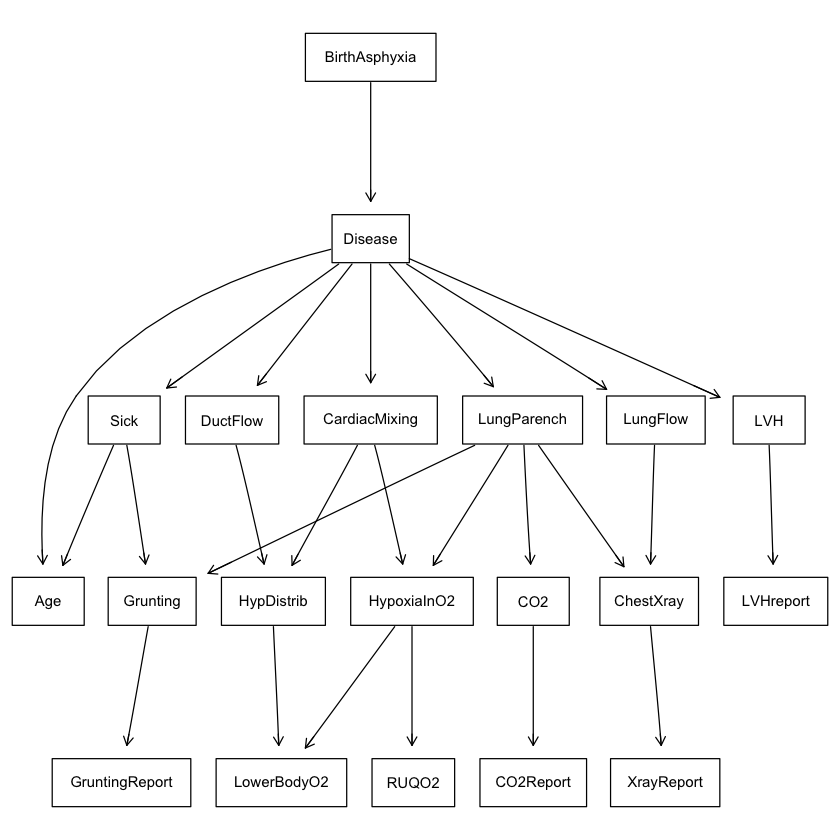

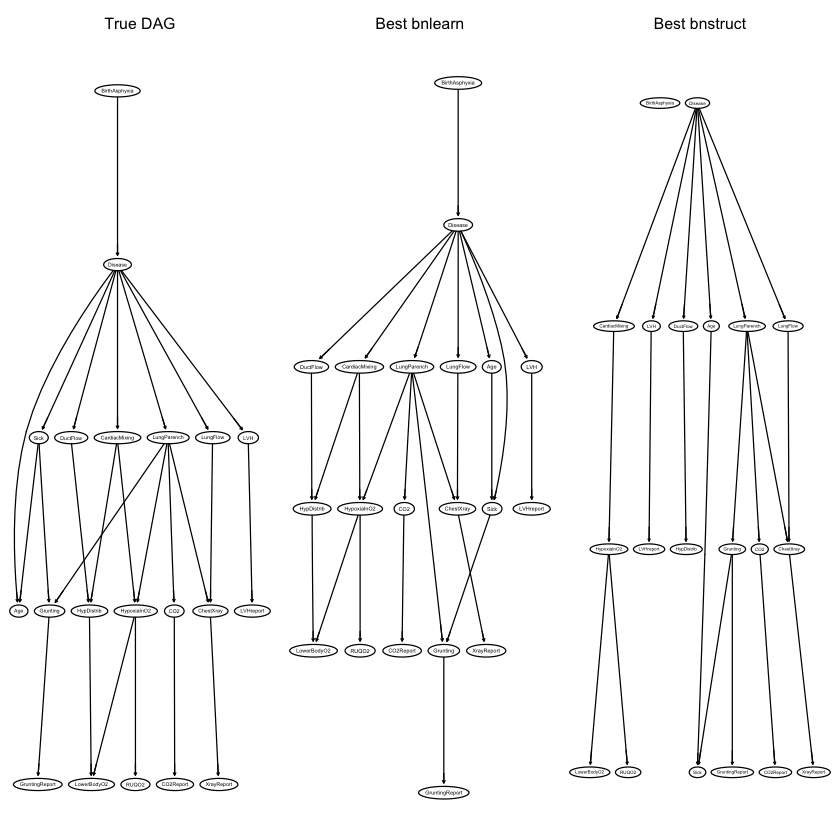

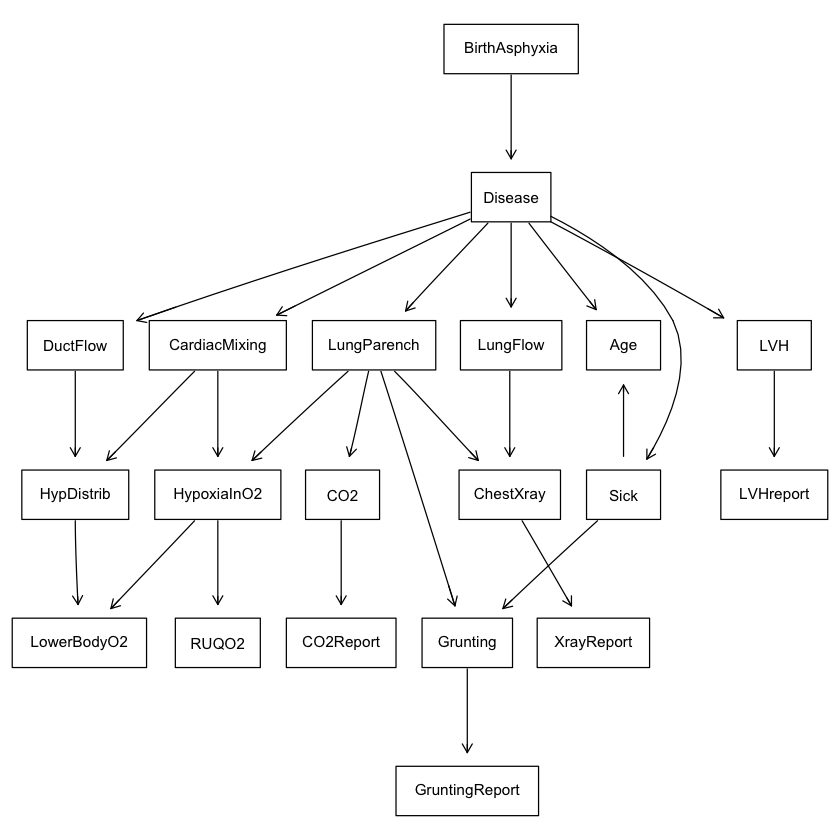

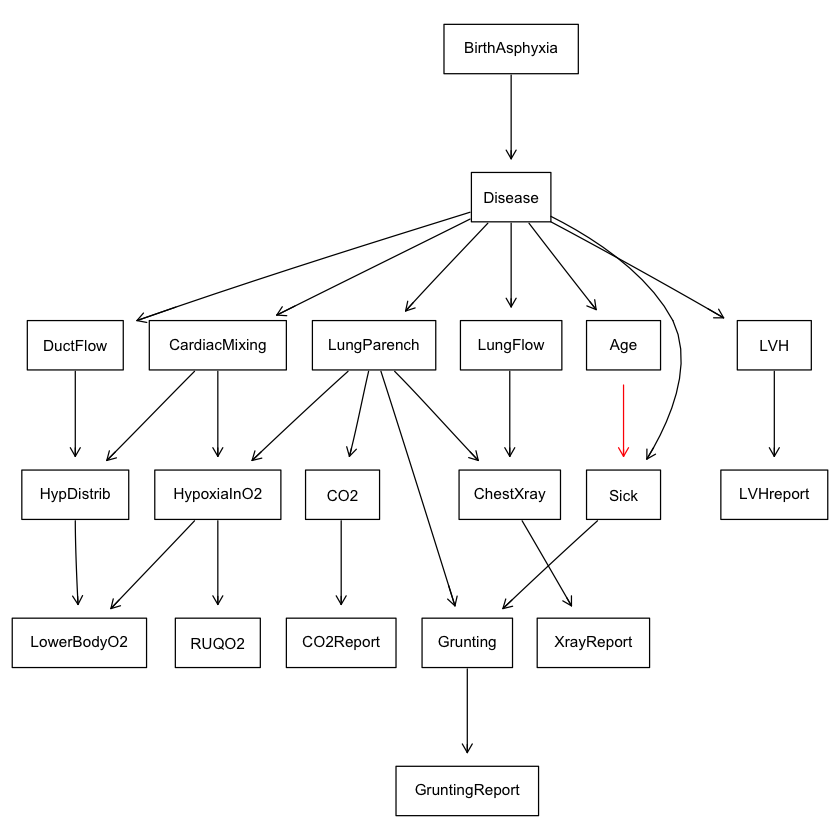

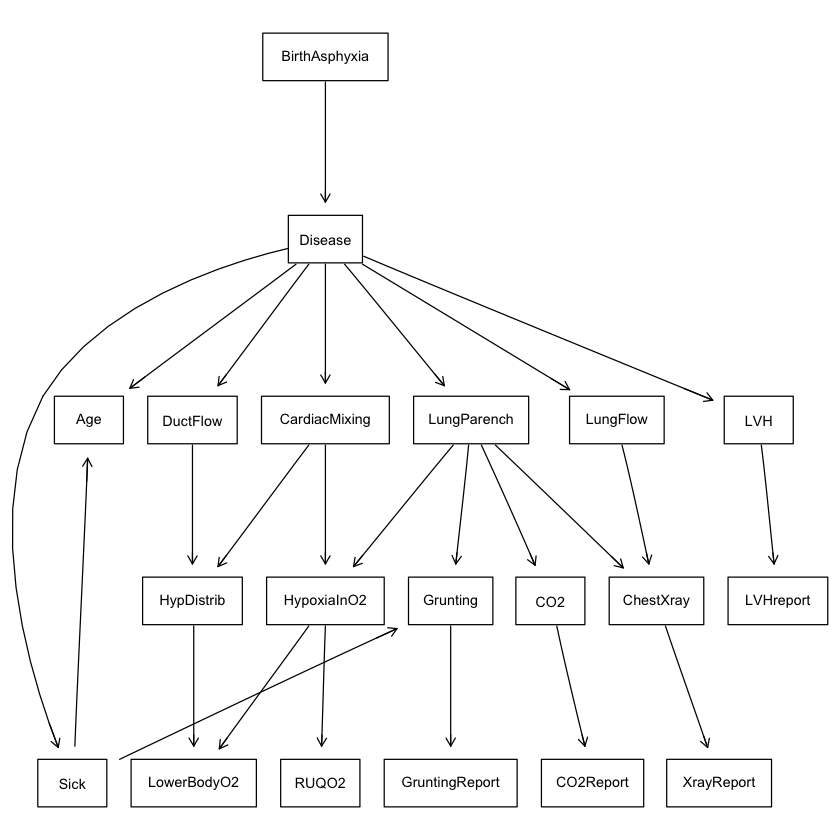


==== Full Summary Table ====
   Method  Algorithm Score MaxParents Test Alpha       BIC SHD
  bnlearn       tabu    k2          2 <NA>    NA -12585.76   2
  bnlearn       tabu    k2          3 <NA>    NA -12585.76   2
  bnlearn       tabu    k2          4 <NA>    NA -12585.76   2
  bnlearn         hc    k2          2 <NA>    NA -12585.76   6
  bnlearn         hc    k2          3 <NA>    NA -12585.76   6
  bnlearn         hc    k2          4 <NA>    NA -12585.76   6
 bnstruct       mmhc  BDeu          2 <NA>    NA -12535.19   9
 bnstruct       mmhc  BDeu          3 <NA>    NA -12535.19   9
 bnstruct       mmhc  BDeu          4 <NA>    NA -12535.19   9
 bnstruct         hc  BDeu          2 <NA>    NA -12535.95  10
 bnstruct         hc  BDeu          3 <NA>    NA -12535.95  10
 bnstruct         hc  BDeu          4 <NA>    NA -12535.95  10
  bnlearn       tabu   bic          2 <NA>    NA -12609.86  15
  bnlearn       tabu   bic          3 <NA>    NA -12609.86  15
  bnlearn       tabu   bi

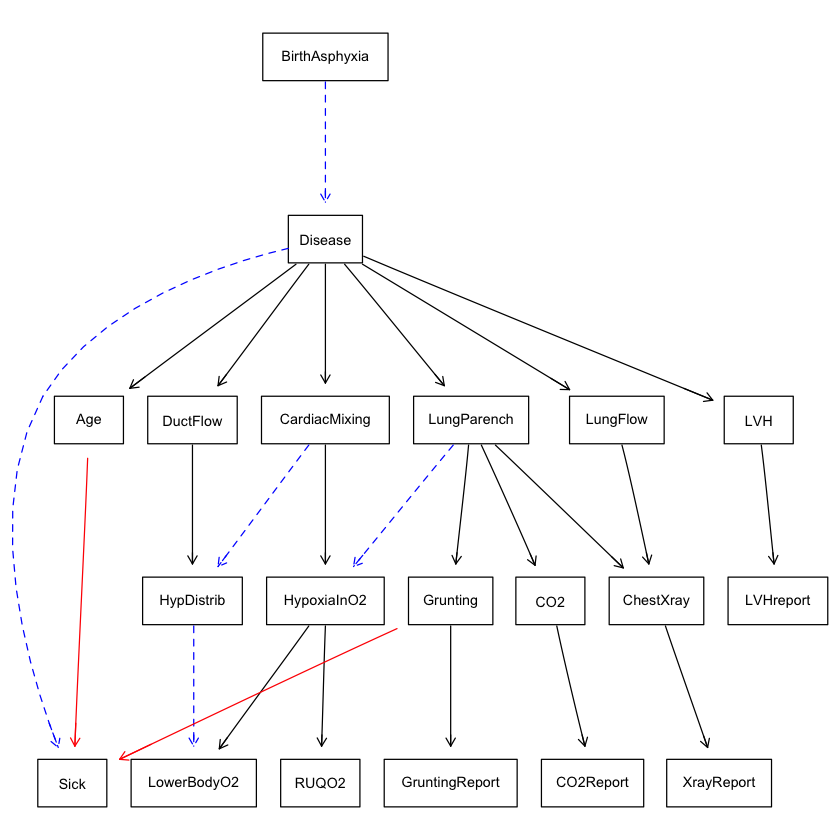

In [30]:
library(bnlearn)
library(bnstruct)
library(Rgraphviz)
library(dplyr)

download.file(
  "https://www.bnlearn.com/bnrepository/child/child.net.gz",
  destfile = "child.net.gz"
)

if (!require("R.utils")) install.packages("R.utils")

download.file("https://www.bnlearn.com/bnrepository/child/child.bif.gz", destfile = "child.bif.gz")
R.utils::gunzip("child.bif.gz", overwrite = TRUE)
child_bn <- bnlearn::read.bif("child.bif")
set.seed(123)
dat <- rbn(child_bn, n = 1000)
node_names <- names(dat)
dag_true <- bnlearn::read.net("child.net")
graphviz.plot(dag_true)
dag_true <- bn.net(dag_true)

# Helper Functions
custom_shd <- function(predicted, true) {
  tryCatch({
    shd(predicted, true)
  }, error = function(e) {
    # Fallback: arc-level SHD
    true_arcs <- apply(arcs(true), 1, paste, collapse = "~")
    pred_arcs <- apply(arcs(predicted), 1, paste, collapse = "~")
    length(setdiff(true_arcs, pred_arcs)) + length(setdiff(pred_arcs, true_arcs))
  })
}

convert_bnstruct_to_bnlearn <- function(net_bs) {
  adj <- slot(net_bs, "dag")
  nodes <- slot(net_bs, "variables")
  arc_mat <- which(adj != 0, arr.ind = TRUE)
  arc_df <- data.frame(
    from = nodes[arc_mat[, 1]],
    to = nodes[arc_mat[, 2]],
    stringsAsFactors = FALSE
  )
  bn <- empty.graph(nodes)
  arcs(bn) <- as.matrix(arc_df)
  stopifnot(setequal(nodes(bn), nodes(dag_true)))  # sanity check
  return(bn)
}
# Grid Definitions
score_grid <- expand.grid(
  algorithm = c("hc", "tabu"),
  score = c("k2", "bic", "bde"),
  maxp = c(2, 3, 4),
  test = NA_character_,
  alpha = NA_real_,
  stringsAsFactors = FALSE
)
cb_grid <- expand.grid(
  algorithm = c("mmhc", "mmpc", "mmmb", "gs", "iamb", "fast.iamb", "inter.iamb"),
  score = NA_character_,
  maxp = NA_integer_,
  test = "mi",
  alpha = c(0.01, 0.05, 0.1, 0.2),
  stringsAsFactors = FALSE
)
algo_grid <- rbind(score_grid, cb_grid)
algo_grid$maxp <- as.integer(algo_grid$maxp)

results <- list()
result_rows_bnlearn <- data.frame(
  method=character(), algorithm=character(), score=character(), maxp=integer(), 
  test=character(), alpha=double(), BIC=numeric(), SHD_REF=integer(), stringsAsFactors=FALSE
)
# bnlearn Search
for (i in seq_len(nrow(algo_grid))) {
  alg <- algo_grid$algorithm[i]
  sc  <- algo_grid$score[i]
  mp  <- algo_grid$maxp[i]
  tst <- algo_grid$test[i]
  a   <- algo_grid$alpha[i]
  
  args <- list(dat)
  if (alg %in% c("hc", "tabu")) {
    args$score <- sc
    args$maxp <- mp
  }
  if (!is.na(tst)) args$test <- tst
  if (!is.na(a)) args$alpha <- a
  
  net <- tryCatch({
    do.call(alg, args)
  }, error=function(e) NULL)
  
  if (!is.null(net)) {
    bic <- tryCatch(score(net, dat, type = "bic"), error = function(e) NA_real_)
    shd_ref <- tryCatch(custom_shd(net, dag_true), error = function(e) NA_integer_)
  } else {
    bic <- NA_real_
    shd_ref <- NA_integer_
  }
  
  result_rows_bnlearn <- rbind(
    result_rows_bnlearn,
    data.frame(
      method="bnlearn", algorithm=alg, score=sc, maxp=mp,
      test=tst, alpha=a, BIC=bic, SHD_REF=shd_ref, stringsAsFactors=FALSE
    )
  )
  key <- paste("bnlearn", alg, sc, mp, tst, a, sep="_")
  results[[key]] <- net
}

cat("Selecting best bnlearn model (min SHD to ground truth)...\n")

best_bnlearn_row <- result_rows_bnlearn %>%
  filter(!is.na(SHD_REF)) %>%
  slice_min(SHD_REF, n = 1)

candidate_keys <- best_bnlearn_row %>%
  transmute(key = paste("bnlearn", algorithm, score, maxp, test, alpha, sep = "_")) %>%
  pull(key)

best_bnlearn_net <- NULL
for (key in candidate_keys) {
  if (!is.null(results[[key]])) {
    best_bnlearn_net <- results[[key]]
    cat("Best model found at key:", key, "\n")
    break
  }
}
if (is.null(best_bnlearn_net)) stop("No valid best bnlearn network found!")

cat("\nBest bnlearn model:\n")
print(best_bnlearn_row)
# bnstruct Search 
cat("Running updated grid search for bnstruct (hc + mmhc)...\n")

data_int <- data.frame(lapply(dat, function(x) as.integer(as.factor(x))))
data_matrix <- as.matrix(data_int)

bnstruct_grid <- expand.grid(
  algorithm = c("hc", "mmhc"),
  score = c("BDeu", "BIC"),
  maxp = c(2, 3, 4),
  stringsAsFactors = FALSE
)

result_rows_bnstruct <- data.frame(
  method = character(), algorithm = character(), score = character(),
  maxp = integer(), BIC = numeric(), SHD_REF = integer(), stringsAsFactors = FALSE
)

for (i in seq_len(nrow(bnstruct_grid))) {
  alg <- bnstruct_grid$algorithm[i]
  sc  <- bnstruct_grid$score[i]
  mp  <- bnstruct_grid$maxp[i]
  
  cat(sprintf(">>> Running bnstruct: algorithm = %s | score = %s | maxp = %d\n", alg, sc, mp))
  
  bndata <- methods::new("BNDataset")
  slot(bndata, "raw.data")      <- as.matrix(data_int)
  slot(bndata, "discreteness")  <- rep(TRUE, ncol(data_int))
  slot(bndata, "variables")     <- colnames(data_int)
  slot(bndata, "node.sizes")    <- apply(data_int, 2, max, na.rm = TRUE) + 1
  slot(bndata, "num.variables") <- ncol(data_int)
  slot(bndata, "has.raw.data")  <- TRUE
  
  net_bs <- tryCatch({
    learn.network(
      x = bndata,
      algo = alg,
      scoring.func = sc,
      max.fanin = mp,
      max.parents = mp
    )
  }, error = function(e) {
    cat(sprintf("!!! Error in learn.network: %s\n", e$message))
    NULL
  })
  
  if (is.null(net_bs)) next
  
  net_bn <- tryCatch({
    convert_bnstruct_to_bnlearn(net_bs)
  }, error = function(e) {
    cat(sprintf("!!! Error in manual conversion: %s\n", e$message))
    NULL
  })
  
  if (is.null(net_bn)) next
  
  bic_bs <- tryCatch(score(net_bn, dat, type = "bic"), error = function(e) NA_real_)
  shd_bs <- tryCatch(custom_shd(net_bn, dag_true), error = function(e) NA_integer_)
  
  cat(sprintf("Stored result: %s | %s | maxp=%d | BIC=%.2f | SHD_REF=%d\n",
              alg, sc, mp, bic_bs, shd_bs))
  
  result_rows_bnstruct <- rbind(
    result_rows_bnstruct,
    data.frame(
      method = "bnstruct",
      algorithm = alg,
      score = sc,
      maxp = mp,
      BIC = bic_bs,
      SHD_REF = shd_bs,
      stringsAsFactors = FALSE
    )
  )
  
  key <- paste("bnstruct", alg, sc, mp, sep = "_")
  results[[key]] <- net_bn
}

cat("\nBest bnstruct network (min SHD to ground truth):\n")
best_bnstruct_row <- result_rows_bnstruct %>%
  filter(!is.na(SHD_REF)) %>%
  slice_min(SHD_REF, n = 1)

if (nrow(best_bnstruct_row) > 0) {
  best_key <- paste("bnstruct",
                    best_bnstruct_row$algorithm[1],
                    best_bnstruct_row$score[1],
                    best_bnstruct_row$maxp[1],
                    sep = "_")
  best_bnstruct_net <- results[[best_key]]
} else {
  best_bnstruct_net <- NULL
}

print(best_bnstruct_row)
# Visual & Quantitative Comparison
cat("\nVisual comparison of best models:\n")
par(mfrow=c(1,3))
graphviz.plot(dag_true, main="True DAG", shape="ellipse")
graphviz.plot(best_bnlearn_net, main="Best bnlearn", shape="ellipse")
graphviz.plot(best_bnstruct_net, main="Best bnstruct", shape="ellipse")
par(mfrow=c(1,1))
# Comparison plots
graphviz.compare(dag_true, best_bnlearn_net)
graphviz.compare(dag_true, best_bnstruct_net)
# Final Summary
result_rows_all <- bind_rows(result_rows_bnlearn, result_rows_bnstruct)

cat("\n==== Full Summary Table ====\n")
summary_table <- result_rows_all %>%
  arrange(SHD_REF, BIC) %>%
  select(Method = method, Algorithm = algorithm, Score = score, MaxParents = maxp,
         Test = test, Alpha = alpha, BIC, SHD = SHD_REF)
print(summary_table, row.names = FALSE)

In [77]:
top_idx_insurance <- which.max(refined_run_insurance$bic_scores)
top_dag_insurance <- refined_run_insurance$dags[top_idx_insurance][[1]]

top_idx_child <- which.max(refined_run_child$bic_scores)
top_dag_child <- refined_run_child$dags[top_idx_child][[1]]

top_idx_asia <- which.max(refined_run_asia$bic_scores)
top_dag_asia <- refined_run_asia$dags[top_idx_asia][[1]]
learned_nodes <- nodes(top_dag_asia)
true_nodes <- nodes(dag_true_asia)
auto_map <- setNames(true_nodes, substr(true_nodes, 1, 1))
top_dag_asia_full <- rename.nodes(top_dag_asia, auto_map)

print(paste("Insurance shd:", bnlearn::shd(top_dag_insurance, dag_true_insurance)))
print(paste("Child shd:", bnlearn::shd(top_dag_child, dag_true_child)))
print(paste("Asia shd:", bnlearn::shd(top_dag_asia_full, dag_true_asia)))

[1] "Insurance shd: 55"
[1] "Child shd: 5"
[1] "Asia shd: 11"
